In [4]:
# ====================================
#               IMPORTS
# ====================================

# GUI Libraries
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
#import pyautogui

# Plotting and Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# KMeans and Data Manipulation
import numpy as np
from sklearn.cluster import KMeans

# Ray-Tracing Simulation
import sionna
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, Camera

# Utility Libraries
#import threading
#import random
import json
import ast
from typing import Dict, List, Tuple
from collections import defaultdict

# Matplotlib Backend Setup
matplotlib.use('TkAgg')  # Use TkAgg backend for embedding plots in Tkinter

# TensorFlow Setup
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
gpu_num = 0  # Specify the GPU to use; leave as "" to use the CPU
# Uncomment to configure GPU/CPU explicitly:
# os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ====================================
#          EXTERNAL FUNCTIONS
# ====================================

def to_db(x):
    """
    Converts a value from a linear scale to decibels (dB).

    :Input:
        **x** (*float* or *tf.Tensor*): A numeric value or a TensorFlow tensor represented in linear scale.

    :Output:
        **dB** (*tf.Tensor*): The value in decibels.
    """
    return 10 * tf.math.log(x) / tf.math.log(10.)

def calculate_cdf(tensor):
    """
    Calculates the cumulative distribution function (CDF) of path gains in a tensor.

    :Input:
        - **tensor** (*tf.Tensor*): A 2D TensorFlow tensor representing a coverage map with path gain values.

    :Output:
        - **sorted_values_db** (*np.ndarray*): Sorted path gain values converted to dB.
        - **cdf** (*np.ndarray*): The cumulative distribution function values.
    """
    # Flatten the tensor and filter out zero or negative values
    tensor_flat = tf.reshape(tensor, [-1])
    non_zero_values = tf.boolean_mask(tensor_flat, tensor_flat > 0.0)

    if tf.size(non_zero_values) == 0:  # Handle empty or zero-only tensors
        return np.array([]), np.array([])

    # Sort values and convert to dB
    sorted_values = tf.sort(non_zero_values)
    sorted_values_db = 10 * tf.math.log(sorted_values) / tf.math.log(10.0)

    # Compute the CDF
    num_values = tf.cast(tf.size(sorted_values), tf.float32)
    cdf = tf.range(1, num_values + 1, dtype=tf.float32) / num_values

    return sorted_values_db.numpy(), cdf.numpy()

def plot_multiple_cdfs(cdfs, labels):
    """
    Plots multiple cumulative distribution functions (CDFs) on the same figure.

    :Input:
        - **cdfs** (*list(tuple(np.ndarray, np.ndarray))*): A list of tuples, where each tuple contains (**sorted_values_db**, **cdf**) for a CDF curve.
        - **labels** (*list(str)*): A list of strings representing the labels for each CDF.

    :Output:
        **figure** (*matplotlib.figure.Figure*): A figure with multiple CDFs plotted, each with distinct marker styles and dashed lines for the CDFs of the distance-based configured RIS-aided scenarios.
    """
    if len(cdfs) != len(labels):
        raise ValueError("The number of CDFs must match the number of labels.")

    plt.figure()
    
    # Plot each CDF
    marker_count = 0
    marker_list = ['o','v','^','<','>','*','x']
    for (sorted_values_db, cdf), label in zip(cdfs, labels):
        if "Distance" in label:
            plt.plot(sorted_values_db, cdf, label=label, marker=marker_list[marker_count], markevery=100, markersize=7, linestyle='--')
        else:
            plt.plot(sorted_values_db, cdf, label=label, marker=marker_list[marker_count], markevery=100, markersize=7)
        marker_count = marker_count + 1

    plt.xlabel('Path gain (dB)')
    plt.ylabel('CDF')
    plt.title('CDF of Path Gains')
    plt.grid(True)
    plt.legend()
    plt.show()

def calculate_coverage_ratio(tensor, threshold_db):
    """
    Calculates the coverage ratio of the scenario from a coverage map tensor based on a minimum path gain threshold.

    :Input:
        - **tensor** (*tf.Tensor*): A 2D TensorFlow tensor representing the coverage map with path gain values.
        - **threshold_db** (*float*): The minimum path gain threshold in dB.

    :Output:
        **coverage_ratio** (*float*): The coverage ratio as a percentage.
    """
    # Convert threshold from dB to decimal
    threshold_decimal = 10 ** (threshold_db / 10)

    # Mask non-zero values (to exclude walls/obstacles) and check which ones are above the threshold
    non_zero_values = tf.boolean_mask(tensor, tf.not_equal(tensor, 0.0))
    above_threshold_mask = non_zero_values > threshold_decimal

    # Ensure we avoid division by zero (if no non-zero values exist)
    num_non_zero = tf.size(non_zero_values, out_type=tf.float32)
    if num_non_zero == 0:
        return 0.0  # Return 0% coverage if no valid data points

    # Calculate the coverage ratio
    coverage_ratio = tf.reduce_sum(tf.cast(above_threshold_mask, tf.float32)) / num_non_zero * 100

    return float(coverage_ratio)  # Return as a float

def selection(coords, k):
    """
    Performs K-means clustering on a set of coordinates and returns the centroids to be appointed as the target points of the RIS.

    This function clusters the provided 3D coordinates based on their x and y values using
    K-means, and assigns the z-value of the first coordinate to all centroids.

    :Input:
        - **coords** (*list* or *np.ndarray*): A list or NumPy array of coordinates, each specified as [x, y, z].
        - **k** (*int*): The number of clusters (centroids) to extract.

    :Output:
        **centroids** (*np.ndarray*): An array of centroids as 3D points with the z-value inherited from the first input coordinate.
    """
    # Convert coords to a NumPy array if it's not already
    coords = np.array(coords)
    
    # Perform K-means clustering to group coordinates based on x and y
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords[:, :2])
    
    # Retrieve centroids of the clusters
    centroids = kmeans.cluster_centers_
    
    # Set the z value to that of the first coordinate's z value
    z_value = coords[0, 2]
    centroids = np.hstack([centroids, np.full((k, 1), z_value)])

    return centroids

# ====================================
#                 GUI
# ====================================

class RIS_GUI:
    def __init__(self, master):
        """
        Initialize the RIS_GUI interface and create the GUI layout.

        This method sets up the main window for the RIS Propagation Optimization GUI.
        It initializes and arranges all widgets including labels, entry fields, buttons,
        option menus, and frames used to input simulation parameters and trigger actions.

        :param master: The root Tkinter window.
        :type master: tk.Tk

        **Attributes Initialized:**
        
        - **self.master**: The main Tkinter window.
        - **self.label_title**: Label displaying the title of the GUI.
        - **self.entry_frame**: Frame containing entry widgets for scenario, frequency, transmitter position,
        minimum path gain threshold, and coverage map cell size.
        - **self.scenario_selection_labelframe**: LabelFrame for selecting the simulation scenario.
        - **self.scenario_options**: List of available scenarios.
        - **self.scenario_var**: Tkinter StringVar holding the currently selected scenario.
        - **self.scenario_menu**: OptionMenu widget for scenario selection.
        - **self.load_scenario_button**: Button to load the selected scenario.
        - **self.frequency_labelframe**: LabelFrame for scene frequency input.
        - **self.entry_frequency**: Entry widget to input the frequency.
        - **self.tx_pos_labelframe**: LabelFrame for transmitter position input.
        - **self.entry_tx_x**, **self.entry_tx_y**, **self.entry_tx_z**: Entry widgets for TX x, y, z coordinates.
        - **self.min_path_gain_threshold_labelframe**: LabelFrame for minimum path gain threshold input.
        - **self.entry_threshold**: Entry widget for the minimum path gain threshold (dB).
        - **self.cov_map_cell_size_labelframe**: LabelFrame for coverage map cell size input.
        - **self.cov_map_cell_size**: Entry widget for cell size.
        - **self.buttons_frame**: Frame containing buttons for preset values, clearing values, previewing the scenario,
        and computing the TX-only coverage map.
        - **self.phase_profile_selection_frame**: Frame containing widgets for selecting the phase profile approach.
        - **self.manual_and_optimization_frame**: Frame that holds both the manual trials and optimization algorithm sections.
        - **Additional frames and widgets**: For manual trials (e.g., clustering, target point selection, RIS position input)
        and for optimization algorithm parameters.
        - **Simulation attributes**: Such as **self.scene**, **self.tx**, **self.ris**, **self.cm_no_ris**, etc., are also initialized
        for later use during simulation computations.

        The method does not return any value.
        """        
        self.master = master
        master.title("RIS Propagation Optimization")

        # Title label
        self.label_title = tk.Label(master, text="Ray-tracing Based RIS Size, Position and Target Point Optimization", font=("Helvetica", 16, "bold"))
        self.label_title.pack(pady=5)

        # Entry Frame
        self.entry_frame = tk.Frame(master)

        # Scenario selection
        self.scenario_selection_labelframe = tk.LabelFrame(self.entry_frame, text="Scenario selection", padx=5, pady=5)
        self.scenario_options = ["U-shaped Indoor Office Scenario for OJAP", "Indoor Office Scenario for EuCAP2025"] #, "L-shaped Hallway Scenario for OJAP", "U-shaped Hallway", "T-shaped Hallway"]
        self.scenario_var = tk.StringVar(value="U-shaped Indoor Office Scenario for OJAP")  # Default to "U-shaped Indoor Office Scenario for OJAP"
        self.scenario_menu = tk.OptionMenu(self.scenario_selection_labelframe, self.scenario_var, *self.scenario_options)
        self.load_scenario_button = tk.Button(self.scenario_selection_labelframe, text="Load", command=self.load_scenario)
        self.scenario_menu.grid(row=0, column=0, padx=5)
        self.load_scenario_button.grid(row=0, column=1, padx=5)
        self.scenario_selection_labelframe.grid(row=0, column=0, padx=5)

        # Frequency input
        self.frequency_labelframe = tk.LabelFrame(self.entry_frame, text="Scene frequency (Hz)", padx=6, pady=6)
        self.entry_frequency = tk.Entry(self.frequency_labelframe, width=7)
        self.entry_frequency.pack(pady=5)        
        self.frequency_labelframe.grid(row=0, column=1, padx=5)

        # TX position input
        self.tx_pos_labelframe = tk.LabelFrame(self.entry_frame, text="TX position (m) (x, y, z)", padx=11, pady=11)
        self.entry_tx_x = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_x.grid(row=0, column=0, padx=5)
        self.entry_tx_y = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_y.grid(row=0, column=1, padx=5)
        self.entry_tx_z = tk.Entry(self.tx_pos_labelframe, width=5)
        self.entry_tx_z.grid(row=0, column=2, padx=5)
        self.tx_pos_labelframe.grid(row=0, column=2, padx=5)

        # Minimum path gain threshold input
        self.min_path_gain_threshold_labelframe = tk.LabelFrame(self.entry_frame, text="Minimum path gain \n threshold (dB)", padx=6, pady=6)
        self.entry_threshold = tk.Entry(self.min_path_gain_threshold_labelframe, width=5)
        self.entry_threshold.pack(pady=5)              
        self.min_path_gain_threshold_labelframe.grid(row=0, column=3, padx=5)

        # Coverage map cell size input
        self.cov_map_cell_size_labelframe = tk.LabelFrame(self.entry_frame, text="Coverage map\ncell size (m)", padx=6, pady=6)
        self.cov_map_cell_size = tk.Entry(self.cov_map_cell_size_labelframe, width=5)
        self.cov_map_cell_size.pack(pady=5)              
        self.cov_map_cell_size_labelframe.grid(row=0, column=4, padx=5)          

        self.entry_frame.pack(pady=5)

        # Buttons Frame
        self.buttons_frame = tk.Frame(master)
        
        # Preset button
        self.button_preset = tk.Button(self.buttons_frame, text="Preset parameters", command=self.set_preset_values, padx=20)
        self.button_preset.grid(row=0, column=0, padx=5)
        
        # Clear button
        self.button_clear = tk.Button(self.buttons_frame, text="Clear parameters", command=self.clear_values, padx=20)
        self.button_clear.grid(row=0, column=1, padx=5)
        
        # Preview button
        self.button_preview = tk.Button(self.buttons_frame, text="Preview scenario", command=self.preview_scenario, padx=20)
        self.button_preview.grid(row=0, column=2, padx=5)
        
        # Compute TX-Only Coverage button
        self.button_TX_coverage = tk.Button(self.buttons_frame, text="Compute TX-only coverage map", command=self.compute_tx_coverage, padx=20)
        self.button_TX_coverage.grid(row=0, column=3, padx=5)
        
        self.buttons_frame.pack(pady=5)

        # Phase Profile selection
        self.phase_profile_selection_frame = tk.Frame(master)
        self.label_pp = tk.Label(self.phase_profile_selection_frame, text="Choose phase profile approach:")
        self.pp_var = tk.StringVar(value="Gradient-based")
        self.pp_options = ["Gradient-based", "Distance-based", "Manual entry"]
        self.pp_menu = tk.OptionMenu(self.phase_profile_selection_frame, self.pp_var, *self.pp_options, command=self.toggle_manual_pp_entry)
        
        self.label_pp.grid(row=0, column=0, padx=5)
        self.pp_menu.grid(row=0, column=1, padx=5)

        # Manual phase profile file selection (Initially hidden)
        self.manual_pp_file_selection_labelframe = tk.LabelFrame(self.phase_profile_selection_frame, text="Select manual phase profile file (.json)", padx=6, pady=6)
        self.manual_pp_file_selection_entry = tk.Entry(self.manual_pp_file_selection_labelframe, width=50)
        self.manual_pp_file_selection_entry.grid(row=0, column=0, padx=5)
        self.manual_pp_file_selection_button = tk.Button(self.manual_pp_file_selection_labelframe, text="Browse", command=self.manual_pp_file_selection)
        self.manual_pp_file_selection_button.grid(row=0, column=1, padx=5)
        self.manual_pp_file_selection_labelframe.grid(row=0, column=2, padx=5)
        self.manual_pp_file_selection_labelframe.grid_remove()
        
        self.phase_profile_selection_frame.pack(pady=5)
        
        # Manual and optimization frame
        self.manual_and_optimization_frame = tk.Frame(master)

        # Manual trials (left-side)
        self.manual_trials_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Manual trials", padx=6, pady=6)
        
        # Enter Number of Target Points of RIS
        self.num_target_labelframe = tk.LabelFrame(self.manual_trials_labelframe, text="Number of target points", padx=6, pady=6)
        self.entry_num_target = tk.Entry(self.num_target_labelframe, width=5)
        self.entry_num_target.pack()
        self.num_target_labelframe.pack(pady=5)   

        # Clustering algorithm button
        self.button_clustering = tk.Button(self.manual_trials_labelframe, text="Find the target point(s) via clustering algorithm",
                                           command=self.clustering_algo)
        self.button_clustering.pack(pady=5)

        # RIS target point(s) choice (Algorithm or manual)
        self.ris_target_points_frame = tk.Frame(self.manual_trials_labelframe)
        self.target_point_manual_optimized = tk.StringVar(value="optimized")  # Start with Optimized
        self.target_point_optimized_radio = tk.Radiobutton(self.ris_target_points_frame,
                                                       text="Use the target point(s) found via clustering algorithm",
                                                       variable=self.target_point_manual_optimized, value="optimized",
                                                       command=self.toggle_target_point_input)
        self.target_point_manual_radio = tk.Radiobutton(self.ris_target_points_frame,
                                                    text="Enter the target point(s) manually", variable=self.target_point_manual_optimized,
                                                    value="manual", command=self.toggle_target_point_input)
        self.target_point_optimized_radio.grid(row=0, column=0, padx=5)
        self.target_point_manual_radio.grid(row=1, column=0, padx=5)
        self.ris_target_points_frame.pack(pady=5)        

        # Compute potential RIS positions
        self.button_coverage = tk.Button(self.manual_trials_labelframe, text="Compute feasible RIS positions",
                                         command=self.compute_potential_RIS_positions)
        self.button_coverage.pack(pady=5)

        # RIS position input
        self.RIS_position_labelframe = tk.LabelFrame(self.manual_trials_labelframe, text="Enter RIS center position (m)\n(x, y, z)", padx=6, pady=6)
        self.entry_ris_x = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_y = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_z = tk.Entry(self.RIS_position_labelframe, width=5)
        self.entry_ris_x.grid(row=0, column=0, padx=5)
        self.entry_ris_y.grid(row=0, column=1, padx=5)
        self.entry_ris_z.grid(row=0, column=2, padx=5)
        self.RIS_position_labelframe.pack(pady=5)

        self.ris_size_frame = tk.Frame(self.manual_trials_labelframe)
        self.label_ris_height = tk.Label(self.ris_size_frame, text="RIS height (m):")
        self.label_ris_width = tk.Label(self.ris_size_frame, text="RIS width (m):")
        self.entry_ris_height = tk.Entry(self.ris_size_frame, width=5)
        self.entry_ris_width = tk.Entry(self.ris_size_frame, width=5)

        self.label_ris_height.grid(row=0, column=0, padx=5)
        self.entry_ris_height.grid(row=0, column=1, padx=5)
        self.label_ris_width.grid(row=1, column=0, padx=5)
        self.entry_ris_width.grid(row=1, column=1, padx=5)

        self.ris_size_frame.pack(pady=5)

        # Show phase profiles button
        self.button_show_phase_profile = tk.Button(self.manual_trials_labelframe, text="Show and export phase profiles",
                                                  command=self.show_phase_profiles)
        self.button_show_phase_profile.pack(pady=5)

        # Checkbox for enabling amplitude fluctuations
        self.amp_fluc_checkbox_var = tk.BooleanVar()
        self.amp_fluc_checkbox = tk.Checkbutton(
            self.manual_trials_labelframe,
            text="Enable uniform random RIS element\namplitude fluctuations (range: [0.0, 1.0])",
            variable=self.amp_fluc_checkbox_var,
            command=self.toggle_amp_fluc_entries
        )
        self.amp_fluc_checkbox.pack(pady=5)

        # Interval entry fields (initially disabled)
        self.amp_fluc_interval_labelframe = tk.LabelFrame(
            self.manual_trials_labelframe,
            text="Lower and upper bounds\nfor amplitude fluctuations",
            padx=6, pady=6
        )
        self.amp_fluc_interval_labelframe.grid_columnconfigure((0, 1), weight=1)
        self.entry_amp_fluc_lower = tk.Entry(self.amp_fluc_interval_labelframe, width=5, state="disabled")
        self.entry_amp_fluc_upper = tk.Entry(self.amp_fluc_interval_labelframe, width=5, state="disabled")
        self.entry_amp_fluc_lower.grid(row=0, column=0, padx=5)
        self.entry_amp_fluc_upper.grid(row=0, column=1, padx=5)
        self.amp_fluc_interval_labelframe.pack(pady=5)        
        
        # Compute combined coverage map button
        self.button_combined_coverage = tk.Button(self.manual_trials_labelframe, text="Compute combined coverage map (TX + RIS)",
                                                  command=self.compute_combined_coverage)
        self.button_combined_coverage.pack(pady=5)

        # Sensitivity analysis
        self.sensitivity_labelframe = tk.LabelFrame(self.manual_trials_labelframe, text="Phase error sensitivity analysis", padx=6, pady=6)

        self.delta_labelframe = tk.LabelFrame(self.sensitivity_labelframe, text="Maximum magnitude of phase error (in degrees) \n (delta_lower, delta_upper, delta_step)", padx=6, pady=6)
        self.delta_labelframe.grid_columnconfigure((0, 1, 2), weight=1)
        self.delta_lower = tk.Entry(self.delta_labelframe, width=5)
        self.delta_upper = tk.Entry(self.delta_labelframe, width=5)
        self.delta_step = tk.Entry(self.delta_labelframe, width=5)
        self.delta_lower.grid(row=0, column=0, padx=5)
        self.delta_upper.grid(row=0, column=1, padx=5)
        self.delta_step.grid(row=0, column=2, padx=5)        
        self.delta_labelframe.pack(pady=5)

        self.num_realization_frame = tk.Frame(self.sensitivity_labelframe)
        self.label_num_realization = tk.Label(self.num_realization_frame, text="Number of realizations:")
        self.entry_num_realization = tk.Entry(self.num_realization_frame, width=5)

        self.label_num_realization.grid(row=0, column=0, padx=5)
        self.entry_num_realization.grid(row=0, column=1, padx=5)

        self.num_realization_frame.pack(pady=5)

        self.sensitivity_checkbox_frame = tk.Frame(self.sensitivity_labelframe)
        self.gradient_based_checkbox_var = tk.BooleanVar()
        self.distance_based_checkbox_var = tk.BooleanVar()
        self.manual_entry_checkbox_var = tk.BooleanVar()
        self.gradient_based_checkbox = tk.Checkbutton(self.sensitivity_checkbox_frame, text="For gradient-based", variable=self.gradient_based_checkbox_var)
        self.distance_based_checkbox = tk.Checkbutton(self.sensitivity_checkbox_frame, text="For distance-based", variable=self.distance_based_checkbox_var)
        self.manual_entry_checkbox = tk.Checkbutton(self.sensitivity_checkbox_frame, text="For manual entry", variable=self.manual_entry_checkbox_var)
        self.gradient_based_checkbox.grid(row=0, column=0, padx=5)
        self.distance_based_checkbox.grid(row=0, column=1, padx=5)
        self.manual_entry_checkbox.grid(row=1, column=0, columnspan=2, padx=5)

        self.sensitivity_checkbox_frame.pack(pady=5)

        self.button_sensitivity = tk.Button(self.sensitivity_labelframe, text="Start phase error sensitivity analysis", command=self.sensitivity_analysis)
        self.button_sensitivity.pack(pady=5)        

        self.sensitivity_labelframe.pack(pady=5)
        
        self.manual_trials_labelframe.grid(row=0, column=0, padx=5)

        # Manual target point entries (Initially hidden)
        self.target_positions_frame = tk.LabelFrame(self.manual_and_optimization_frame, text="Manual target point entries", padx=6, pady=6)
        self.target_positions_frame.grid(row=0, column=1, padx=5)
        self.target_positions_frame.grid_remove()

        # Optimization algorithm (right-side)
        self.optimization_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Optimization algorithm", padx=6, pady=6)

        # Number of target point interval
        self.num_target_interval_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                            text="Number of target point interval \n (N_lower, N_upper, N_step)", padx=6, pady=6)
        self.num_target_interval_labelframe.grid_columnconfigure((0, 1, 2), weight=1)
        self.N_lower = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_upper = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_step = tk.Entry(self.num_target_interval_labelframe, width=5)
        self.N_lower.grid(row=0, column=0, padx=5)
        self.N_upper.grid(row=0, column=1, padx=5)
        self.N_step.grid(row=0, column=2, padx=5)        
        self.num_target_interval_labelframe.pack(pady=5)

        # RIS height
        self.ris_height_labelframe = tk.LabelFrame(self.optimization_labelframe, text="RIS height (m)", padx=6, pady=6)
        self.ris_height_opt_algo = tk.Entry(self.ris_height_labelframe, width=5)
        self.ris_height_opt_algo.pack()
        self.ris_height_labelframe.pack()

        # RIS width interval
        self.ris_width_interval_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                            text="RIS width interval (m)\n (W_RIS_lower, W_RIS_upper, W_RIS_step)", padx=6, pady=6)
        self.ris_width_interval_labelframe.grid_columnconfigure((0, 1, 2), weight=1)
        self.w_ris_lower = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_upper = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_step = tk.Entry(self.ris_width_interval_labelframe, width=5)
        self.w_ris_lower.grid(row=0, column=0, padx=5)
        self.w_ris_upper.grid(row=0, column=1, padx=5)
        self.w_ris_step.grid(row=0, column=2, padx=5)        
        self.ris_width_interval_labelframe.pack(pady=5)

        # Metric computation technique
        self.metric_comp_tech_labelframe = tk.LabelFrame(self.optimization_labelframe, text="Metric computation technique", padx=6, pady=6)
        self.metric_comp_tech = tk.StringVar(value="Using coverage map")
        self.metric_comp_tech_options = ["Using coverage map", "Using individual path computation"]
        self.metric_comp_tech_menu = tk.OptionMenu(self.metric_comp_tech_labelframe, self.metric_comp_tech, *self.metric_comp_tech_options)
        self.metric_comp_tech_menu.pack()
        self.metric_comp_tech_labelframe.pack(pady=5)

        # Compute sub-optimal optimization parameters
        self.button_compute_opt_par = tk.Button(self.optimization_labelframe, text="Compute performance metrics for all N, W_RIS, r_RIS", command=self.compute_opt_par)
        self.button_compute_opt_par.pack(pady=5)
        
        # Performance metric file selection
        self.data_file_selection_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Select performance metric file (.json)", padx=6, pady=6)
        self.data_file_selection_entry = tk.Entry(self.data_file_selection_labelframe, width=50)
        self.data_file_selection_entry.grid(row=0, column=0, padx=5)
        self.data_file_selection_button = tk.Button(self.data_file_selection_labelframe, text="Browse", command=self.data_file_selection)
        self.data_file_selection_button.grid(row=0, column=1, padx=5)
        self.data_file_selection_labelframe.pack(pady=5)

        # Coverage ratio file selection
        self.cov_ratio_selection_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Select coverage ratio file (.json)", padx=6, pady=6)
        self.cov_ratio_selection_entry = tk.Entry(self.cov_ratio_selection_labelframe, width=50)
        self.cov_ratio_selection_entry.grid(row=0, column=0, padx=5)
        self.cov_ratio_selection_button = tk.Button(self.cov_ratio_selection_labelframe, text="Browse", command=self.cov_ratio_selection)
        self.cov_ratio_selection_button.grid(row=0, column=1, padx=5)
        self.cov_ratio_selection_labelframe.pack(pady=5)

        # Performance metric vs. RIS width
        self.perf_metr_RIS_width_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Performance metric vs. RIS width and determine sub-optimal RIS parameters\n(N^opt, W_RIS^opt, r^opt)", padx=6, pady=6)
        # Performance improvement threshold
        self.perf_impr_thre_labelframe = tk.LabelFrame(self.perf_metr_RIS_width_labelframe,
                                                           text="Performance improvement threshold (dB)", padx=6, pady=6)
        self.perf_impr_thre = tk.Entry(self.perf_impr_thre_labelframe, width=5)
        self.perf_impr_thre.pack()
        self.perf_impr_thre_labelframe.pack(pady=5) 
        # Run button
        self.run_opt_algorithm_button = tk.Button(self.perf_metr_RIS_width_labelframe, text="Plot performance metric vs. RIS width and\ndetermine sub-optimal RIS parameters",
                                                  command=self.run_opt_algorithm)
        self.run_opt_algorithm_button.pack()
        self.perf_metr_RIS_width_labelframe.pack(pady=5)

        # Performance metric vs. RIS position
        self.perf_metr_RIS_pos_labelframe = tk.LabelFrame(self.optimization_labelframe,
                                                           text="Performance metric vs. RIS position", padx=6, pady=6)
        # State RIS width
        self.perf_metr_RIS_pos_width_labelframe = tk.LabelFrame(self.perf_metr_RIS_pos_labelframe,
                                                           text="RIS width included in the JSON file (m)", padx=6, pady=6)
        self.perf_metr_RIS_pos_width = tk.Entry(self.perf_metr_RIS_pos_width_labelframe, width=5)
        self.perf_metr_RIS_pos_width.pack()
        self.perf_metr_RIS_pos_width_labelframe.pack(pady=5)
        # Run button
        self.perf_metr_RIS_pos_button = tk.Button(self.perf_metr_RIS_pos_labelframe, text="Plot performance metric vs. RIS position given the entered RIS width",
                                                  command=self.perf_metr_RIS_pos_func)
        self.perf_metr_RIS_pos_button.pack()
        self.perf_metr_RIS_pos_labelframe.pack(pady=5)
        
        self.optimization_labelframe.grid(row=0, column=2, padx=5)
        # Information messages frame
        self.message_labelframe = tk.LabelFrame(self.manual_and_optimization_frame, text="Messages")
        self.info_label = tk.Label(self.message_labelframe, text="", font=("", 8, "bold"), fg="green")
        self.info_label.pack_forget()
        self.message_labelframe.grid(row=0, column=3, padx=5)
        
        self.manual_and_optimization_frame.pack(pady=5)
        

        # Scene initialization
        self.scene = None
        self.tx = None
        self.ris = None
        self.cm_no_ris = None
        # Initialize a list to store the steering positions
        self.position_entries = []
        self.tx_position = []
        self.ris_position = []
        self.RX_coord_set = []
        self.metric = {}
        self.metric_below_threshold_count = {}
        self.metric_coverage_ratio = {}
        self.cdfs = []
        self.cdf_labels = []
        self.cov_ratio_no_ris = None
        self.low_power_cell_coords = []
        self.low_power_cell_values = []
        self.low_power_cell_map_indices = []
        self.avg_path_gain_low_power_cells_no_ris = None    
        self.outer_wall_thickness = 0.4 # outer_wall_thickness of indoor office scenario is 0.4 m
        self.zero_indices = []
        self.RIS_search_positions = []
        self.cdf_no_ris = None
    
    # Functions and Methods
    def toggle_amp_fluc_entries(self):
        state = "normal" if self.amp_fluc_checkbox_var.get() else "disabled"
        self.entry_amp_fluc_lower.config(state=state)
        self.entry_amp_fluc_upper.config(state=state)
        
    def manual_pp_file_selection(self):
        """Opens file dialog to select a manual phase profile JSON file."""
        filename = filedialog.askopenfilename(filetypes=[("JSON Files", "*.json")])
        if filename:
            self.manual_pp_file_selection_entry.delete(0, tk.END)
            self.manual_pp_file_selection_entry.insert(0, filename)

    def toggle_manual_pp_entry(self, selected_option):
        """Shows the manual phase profile file selection when 'Manual entry' is chosen."""
        if selected_option == "Manual entry":
            self.manual_pp_file_selection_labelframe.grid(row=0, column=2, padx=5)
        else:
            self.manual_pp_file_selection_labelframe.grid_remove()

    def manual_pp_config(self):
        """Loads a manually provided phase profile from a JSON file and applies it to the RIS."""
        try:
            # Get the file path from the entry field
            file_path = self.manual_pp_file_selection_entry.get()
            if not file_path:
                self.info_label.config(text=self.info_label.cget("text") + "\nNo manual phase profile file selected! ❌")
                return
    
            # Load JSON data
            with open(file_path, 'r') as file:
                phase_data = json.load(file)
    
            # Convert JSON data (list of lists) into a TensorFlow tensor
            phase_tensor = tf.convert_to_tensor(phase_data, dtype=tf.float32)
    
            # Check dimensions and update RIS phase profile
            if len(phase_tensor.shape) != 3:
                self.info_label.config(text=self.info_label.cget("text") + "\nInvalid phase profile format! Expected a 3D list. ❌")
                return
    
            # Assign the loaded phase profile to the RIS object
            self.ris.phase_profile.values = phase_tensor
    
            self.info_label.config(text=self.info_label.cget("text") + "\nManual phase profile successfully loaded and applied! ✅")
    
        except Exception as e:
            self.info_label.config(text=self.info_label.cget("text") + f"\nError loading manual phase profile: {str(e)} ❌")
        
    def load_scenario(self):
        """
        Loads the simulation scene based on the selected scenario and initializes the scene parameters.

        This method reads the currently selected scenario from the GUI (via `self.scenario_var`) and loads the corresponding scene using 
        the `load_scene` function. For some scenarios, it also sets up wall indices (`self.zero_indices`) and defines potential RIS 
        placement positions (`self.RIS_search_positions`).
        """        
        # Load the scene
        if self.scenario_var.get() == "U-shaped Indoor Office Scenario for OJAP":
            self.scene = load_scene("Scenarios/Indoor_Office_Scenario_OJAP/Indoor_Scenario_OJAP.xml")
            # Indicating the wall indices in the coverage map
            self.zero_indices = [
                [[0, 0, i] for i in range(42)],
                [[0, i, 0] for i in range(42)],
                [[0, 41, i] for i in range(42)],
                [[0, i, 41] for i in range(42)],
                [[0, 16, i] for i in range(11,26)],
                [[0, 34, i] for i in range(11,26)],
                [[0, i, 11] for i in range(27,34)],
                [[0, i, j] for i in range(1,9) for j in range(11,41)],
                [[0, i, j] for i in range(16,41) for j in range(26,41)]
            ]
            # Define walls for RIS placement
            self.RIS_search_positions = [
                {"fixed_coord": "x", "fixed_value": 0.1, "variable_coord": "y", "min": 0.1, "max": 15.9},
                {"fixed_coord": "y", "fixed_value": 0.1, "variable_coord": "x", "min": 0.1, "max": 3.9},
            ]             
        elif self.scenario_var.get() == "Indoor Office Scenario for EuCAP2025":
            self.scene = load_scene("Scenarios/Indoor_Office_Scenario/Indoor_Scenario.xml")
            # Indicating the wall indices in the coverage map
            self.zero_indices = [
                [[0, 0, i] for i in range(27)],
                [[0, i, 0] for i in range(52)],
                [[0, 51, i] for i in range(27)],
                [[0, i, 26] for i in range(52)],
                [[0, 13, i] for i in range(13, 27)],
                [[0, 31, i] for i in range(13, 27)],
                [[0, i, 13] for i in range(13, 17)],
                [[0, i, 13] for i in range(24, 32)]
            ]
            # Define walls for RIS placement
            self.RIS_search_positions = [
                {"fixed_coord": "y", "fixed_value": 0.1, "variable_coord": "x", "min": 0.4, "max": self.scene.size[0]},
                {"fixed_coord": "x", "fixed_value": 0.1, "variable_coord": "y", "min": 0.4, "max": self.scene.size[1]},
                {"fixed_coord": "y", "fixed_value": self.scene.size[1], "variable_coord": "x", "min": 0.4, "max": self.scene.size[0]},
                {"fixed_coord": "x", "fixed_value": self.scene.size[0], "variable_coord": "y", "min": 0.4, "max": self.scene.size[1]},
            ]                        
        elif self.scenario_var.get() == "L-shaped Hallway Scenario for OJAP":
            self.scene = load_scene("Scenarios/L-shaped_Hallway_Scenario_OJAP/L-shaped_Hallway_Scenario_OJAP.xml")
        elif self.scenario_var.get() == "U-shaped Hallway":
            self.scene = load_scene("Scenarios/U-Shaped_Scenario/U-shaped.xml")
        elif self.scenario_var.get() == "T-shaped Hallway":
            self.scene = load_scene("Scenarios/T-Shaped_Scenario/T-shaped.xml")
        

        # Check if the scene was loaded correctly
        if not self.scene:
            raise ValueError("Failed to load the scene! ❌")

        # Set up TX and RX arrays
        self.scene.tx_array = PlanarArray(1, 1, 0.5, 0.5, "iso", "V")
        self.scene.rx_array = PlanarArray(1, 1, 0.5, 0.5, "iso", "V")
        
        # Update the info label to show successful load
        self.info_label.pack(pady=5)
        self.info_label.config(text=self.info_label.cget("text") + "\n Scene loaded successfully! ✅")

    def set_preset_values(self):
        """
        Sets preset parameter values for the GUI entries.

        This method resets and assigns default values to the frequency, minimum path gain threshold, 
        and coverage map cell size entry fields. Additionally, it sets the transmitter's 
        coordinates based on the currently selected scenario.
        """
        # Set general preset values
        self.entry_frequency.delete(0, tk.END)
        self.entry_frequency.insert(0, '5.8e9')
    
        self.entry_threshold.delete(0, tk.END)
        self.entry_threshold.insert(0, '-99')

        self.cov_map_cell_size.delete(0, tk.END)
        self.cov_map_cell_size.insert(0, '0.4')
    
        # Define a helper function to set TX coordinates
        def set_tx_coordinates(x, y, z):
            self.entry_tx_x.delete(0, tk.END)
            self.entry_tx_x.insert(0, str(x))
            self.entry_tx_y.delete(0, tk.END)
            self.entry_tx_y.insert(0, str(y))
            self.entry_tx_z.delete(0, tk.END)
            self.entry_tx_z.insert(0, str(z))
    
        # Set TX coordinates based on the selected scenario
        scenario = self.scenario_var.get()
        if scenario == "U-shaped Indoor Office Scenario for OJAP":
            set_tx_coordinates(3.6, 15.9, 2)        
        elif scenario == "Indoor Office Scenario for EuCAP2025":
            set_tx_coordinates(3.8, 19.7, 2)
        elif scenario == "L-shaped Hallway Scenario for OJAP":
            set_tx_coordinates(13.9, 14, 2)
        elif scenario == "U-shaped Hallway":
            set_tx_coordinates(1, 14.7, 2)
        elif scenario == "T-shaped Hallway":
            set_tx_coordinates(2.6, 0.3, 2)
    
    def clear_values(self):
        """
        Clears the entry fields for the frequency, minimum path gain threshold, transmitter position (x, y, and z) and coverage map cell size.
        """      
        self.entry_frequency.delete(0, tk.END)
        self.entry_threshold.delete(0, tk.END)
        self.entry_tx_x.delete(0, tk.END)
        self.entry_tx_y.delete(0, tk.END)
        self.entry_tx_z.delete(0, tk.END)
        self.cov_map_cell_size.delete(0, tk.END)

    def preview_scenario(self):
        """
        Previews the current scenario by rendering the scene with the transmitter and RIS (if present).

        This method configures and displays the simulation setup based on the selected scenario. It reads
        input parameters from the GUI, sets up the transmitter at the specified position, and optionally
        adds a RIS if dimensions are provided. The scene is then rendered from one or more camera viewpoints.

        :Output:
            Rendered figures (*matplotlib.figure.Figure*): Figures rendered from different predefined camera viewpoints.
        """
        try:
            self.scene.frequency = float(self.entry_frequency.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\n Invalid frequency value entered! ❌")
            return
    
        # Transmitter position
        self.tx_position = [float(self.entry_tx_x.get()), float(self.entry_tx_y.get()), float(self.entry_tx_z.get())]
        self.scene.remove("tx")
        self.tx = Transmitter(name="tx", position=self.tx_position)
        self.scene.add(self.tx)
    
        # Remove previous RIS if any
        self.scene.remove("ris")
        
        # Adding RIS if dimensions are provided
        if self.entry_ris_height.get() and self.entry_ris_width.get():
            try:
                ris_height = float(self.entry_ris_height.get())
                ris_width = float(self.entry_ris_width.get())
                num_rows = int(ris_height / (0.5 * self.scene.wavelength))
                num_cols = int(ris_width / (0.5 * self.scene.wavelength))
                self.ris_position = [float(self.entry_ris_x.get()), float(self.entry_ris_y.get()), float(self.entry_ris_z.get())]
                self.ris = RIS(name="ris", position=self.ris_position, num_rows=num_rows, num_cols=num_cols)
                self.scene.add(self.ris)
                self.tx.look_at(self.ris)  # Transmitter points towards the RIS
                
            except ValueError:
                self.info_label.config(text=self.info_label.cget("text") + "\n Invalid RIS dimensions entered! ❌")
                return
    
        # Camera setup for different scenarios
        scenario = self.scenario_var.get()
        if scenario == "U-shaped Indoor Office Scenario for OJAP":
            self.scene.remove("my_cam1")
            #self.scene.remove("my_cam2")
            
            # Reusable camera creation and adding to scene
            camera_positions = [
                ([23, -13, 30], [7, 8, 2])
                #([5, -13, 30], [7, 8, 2])
            ]
            
            cameras = []
            for i, (position, look_at) in enumerate(camera_positions, 1):
                cam = Camera(f"my_cam{i}", position=position, look_at=look_at)
                self.scene.add(cam)
                cameras.append(cam)

        elif scenario == "Indoor Office Scenario for EuCAP2025":
            self.scene.remove("my_cam1")
            self.scene.remove("my_cam2")
            self.scene.remove("my_cam3")
            
            # Reusable camera creation and adding to scene
            camera_positions = [
                ([23, -13, 20], [5, 10, 2]),
                ([5, -13, 20], [5, 10, 2]),
                ([5, 33, 20], [5, 10, 2])
            ]
            
            cameras = []
            for i, (position, look_at) in enumerate(camera_positions, 1):
                cam = Camera(f"my_cam{i}", position=position, look_at=look_at)
                self.scene.add(cam)
                cameras.append(cam)
                
        elif scenario == "L-shaped Hallway Scenario for OJAP":
            pass 
        
        elif scenario == "U-shaped Hallway":
            pass
        
        elif scenario == "T-shaped Hallway":
            pass
            
        # Render from all camera angles
        for cam in cameras:
            fig_render = self.scene.render(cam, show_devices=True, resolution=(2620, 2000))
            fig_render.show()

    def customize_axes(self, tensor, ax):
        """
        Customizes the axes of a coverage map plot.

        This method adjusts the tick labels of the x and y axes based on the coverage map's
        cell size and the outer wall thickness. The tick labels are rounded to one decimal 
        place for clarity.

        :Input:
            - **tensor** (*tf.Tensor*): A 2D tensor representing the coverage map.
            - **ax** (*matplotlib.axes.Axes*): The Matplotlib axes object to customize.
        """
        # Generate tick labels based on cell size
        x_labels = np.arange(self.outer_wall_thickness/2, tensor.shape[1] * float(self.cov_map_cell_size.get()) + (self.outer_wall_thickness/2), 2)  # Adjust step size as needed
        y_labels = np.arange(self.outer_wall_thickness/2, tensor.shape[0] * float(self.cov_map_cell_size.get()) + (self.outer_wall_thickness/2), 4)  # Adjust step size as needed
        ax.set_xticks(ticks=x_labels / float(self.cov_map_cell_size.get()))
        ax.set_xticklabels(np.round(x_labels - (self.outer_wall_thickness/2), 1)) # Round to 1 decimal place
        ax.set_yticks(ticks=y_labels / float(self.cov_map_cell_size.get()))
        ax.set_yticklabels(np.round(y_labels - (self.outer_wall_thickness/2), 1)) # Round to 1 decimal place
        ax.set_xlabel("X-axis (m)")
        ax.set_ylabel("Y-axis (m)")

    def brush_cov_map(self, coverage_map, zero_indices):
        """
        Modifies a 3D coverage map by masking walls of the scene to zero for smoother visibility.

        This method updates the `path_gain` tensor of the coverage map by applying a mask 
        that sets the values of specified wall indices (`zero_indices`) to zero, effectively 
        removing their influence on the coverage visualization.

        **Important:**  
        This function requires an additional method `set_value()` to be added in 
        `sionna/rt/coverage_map.py`, which allows updating the coverage map values.

        **Required Method in sionna/rt/coverage_map.py:**
        
        .. code-block:: python

            def set_value(self, new_value):
                \"\"\"
                Sets a new value for the coverage map.

                :Input:
                    - new_value (tf.Tensor): A tensor of shape [num_tx, num_cells_y, num_cells_x] 
                    representing the new coverage map values.
                \"\"\"
                if hasattr(self, '_value'):
                    if new_value.shape != self._value.shape:
                        raise ValueError(f"Shape mismatch. Expected shape {self._path_gain.shape}, but got {new_value.shape}")

                self._path_gain = tf.cast(new_value, self._rdtype)

        :Input:
            - **coverage_map** (*object*): The coverage map object containing the 3D tensor `path_gain`.
            - **zero_indices** (*list[list[list[int]]]*): A list of indices representing the wall positions to be masked.
        """
        tensor = coverage_map.path_gain
        # Initialize the mask with ones
        mask = tf.ones_like(tensor)

        # Flatten the zero_indices and apply the mask update in one go
        mask = tf.tensor_scatter_nd_update(mask, [index for sublist in zero_indices for index in sublist],
                                        [0] * sum(len(sublist) for sublist in zero_indices))

        # Apply the mask to the tensor and update the coverage map
        modified_tensor = tensor * mask
        coverage_map.set_value(modified_tensor)

    def draw_binary_poor_coverage_map(self, cm_no_ris_tensor, avg_path_gain_low_power_cells, cov_ratio):
        """
        Generates a binary poor coverage map highlighting low-power cells.

        This method visualizes areas with poor coverage in red and acceptable coverage in blue.
        Walls (zero-power cells) are overlaid in white. The method also annotates the plot with
        the selected path gain threshold, the average path gain of low-power cells, and the coverage ratio.
        
        :Input:
            - **cm_no_ris_tensor** (*tf.Tensor*): A 2D tensor representing the coverage map path gain for each transmitter.
            - **avg_path_gain_low_power_cells** (*float*): The average path gain of low-power cells (in dB).
            - **cov_ratio** (*float*): The percentage of area covered above the minimum path gain threshold.

        :Output:
            **fig2** (*matplotlib.figure.Figure*): The generated figure.
        """
        # Get the threshold from the GUI
        threshold = 10 ** (float(self.entry_threshold.get()) / 10)  # dB threshold from the GUI
        
        # Convert the tensor to a numpy array
        coverage_data = cm_no_ris_tensor.numpy()
        
        # Create masks
        zero_power_mask = coverage_data == 0  # Zero-power cells (walls)
        poor_coverage_mask = (coverage_data < threshold) & ~zero_power_mask  # Below threshold, but not walls
        
        # Prepare the display data with distinct values for each category
        display_data = np.zeros_like(coverage_data, dtype=int)
        display_data[poor_coverage_mask] = 1  # Assign '1' for poor coverage

        # Cells with acceptable coverage remain '0'
        
        # Create a new figure for the visualization
        fig2, ax2 = plt.subplots()
        
        # Define a discrete colormap with only blue and red
        cmap = mcolors.ListedColormap(['blue', 'red'])  # Blue for acceptable, red for poor
        bounds = [-0.5, 0.5, 1.5]  # Define boundaries for colormap categories
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Display the main image
        cax2 = ax2.imshow(display_data, origin='lower', cmap=cmap, norm=norm,
                        interpolation='none', aspect='auto')

        # Overlay zero-power cells (walls) as white
        white_overlay = np.full_like(coverage_data, np.nan, dtype=float)  # Create a NaN array
        white_overlay[zero_power_mask] = 1  # Mark walls (zero-power cells) for overlay
        ax2.imshow(white_overlay, origin='lower', cmap=mcolors.ListedColormap(['white']),
                interpolation='none', alpha=1.0)
        
        self.customize_axes(cm_no_ris_tensor, ax2)
        ax2.set_title(f"Binary Poor Coverage Map")

        # Add colorbar with labels for only "Acceptable" and "Poor"
        cbar = fig2.colorbar(cax2, ax=ax2, boundaries=bounds, ticks=[0, 1])
        cbar.ax.set_yticklabels(['Acceptable', 'Poor'])
        cbar.ax.set_yticks([0, 1])  # Set ticks positions
        # Center the tick labels vertically within their respective color sections
        for label in cbar.ax.get_yticklabels():
            label.set_rotation(90)  # Rotate the labels vertically
            label.set_verticalalignment('center')  # Center vertically
        
        ax2.set_facecolor('white')
        ax2.grid(False)
    
        # Add text to the bottom-right corner of the binary poor coverage map
        text_str = (
            f"$P_{{\\mathrm{{th}}}}$ = {float(self.entry_threshold.get()) - 1} dB\n"
            f"Cov. ratio = {cov_ratio:.2f} %\n"
            f"$\\mathcal{{M}}$ = {avg_path_gain_low_power_cells:.2f} dB"
        )

        if self.scenario_var.get() == "U-shaped Indoor Office Scenario for OJAP":
            text_pos = [0.65, 0.05]
        elif self.scenario_var.get() == "Indoor Office Scenario for EuCAP2025":
            text_pos = [0.5, 0.1]

        ax2.text(
            text_pos[0],  # x-coordinate
            text_pos[1],  # y-coordinate
            text_str,
            transform=ax2.transAxes,  # Use axes coordinates
            fontsize=9.5,
            fontname='Arial',
            color='red',
            ha='center',  # Align text to the right
            va='bottom',  # Align text to the bottom
            fontstyle='italic',  # Italic text
            weight='bold'  # Bold text            
            #bbox=dict(facecolor='white', alpha=0)
        )

        # Visualize the transmitter
        ax2.scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")
        ax2.legend(loc='best')

        return fig2

    def select_below_threshold(self, tensor, threshold_db):
        """
        Selects coordinates and values from a 2D coverage map tensor that fall below a given minimum path gain threshold.

        :Input:
            - **tensor** (*tf.Tensor*): A 2D tensor representing the coverage map.
            - **threshold_db** (*float*): The minimum path gain threshold in dB to filter the tensor values.

        :Output:
            - **coords_below_threshold** (*list[list[float]]*): Transformed coordinates (in meters) where path gain values are below the threshold.
            - **value_list** (*list[float]*): The path gain values at those coordinates.
            - **indices** (*np.ndarray*): The indices of the selected values in the original tensor.
        """
        # Convert threshold from dB to decimal
        threshold = 10 ** (threshold_db / 10)

        # Convert the TensorFlow tensor to a NumPy array for easier indexing
        np_tensor = tensor.numpy()
        # Get the indices where the conditions are met: non-zero and below the threshold
        indices = np.argwhere((np_tensor < threshold) & (np_tensor > 0))
        # Get the values at these indices
        values = np_tensor[indices[:, 0], indices[:, 1]]    

        # Transform the indices to the actual coordinates
        coords_below_threshold = [[(b + 0.5) * float(self.cov_map_cell_size.get()) - self.outer_wall_thickness, (a + 0.5) * float(self.cov_map_cell_size.get()) - self.outer_wall_thickness, 1.5] for a, b in indices] # The default coverage map height in Sionna RT is 1.5 m.

        # Convert values to a list
        value_list = values.tolist()

        return coords_below_threshold, value_list, indices

    def compute_tx_coverage(self):
        """
        Computes and visualizes the TX-only coverage map for the scene.

        :Output:
            - **TX-only coverage map** (*visualization*): Displays the coverage map without RIS.
            - **Coverage ratio** (*float*): Percentage of the area above the minimum path gain threshold.
            - **Low-power cell analysis** (*float*): Computes the average path gain of weak coverage areas.
            - **Binary poor coverage map** (*visualization*): Highlights regions with insufficient power.
        """
        try:
            # Set the frequency from the GUI
            self.scene.frequency = float(self.entry_frequency.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid frequency value entered! ❌")
            return
    
        try:
            # Transmitter position setup
            self.tx_position = [float(self.entry_tx_x.get()), float(self.entry_tx_y.get()), float(self.entry_tx_z.get())]
            self.scene.remove("tx")
            self.tx = Transmitter(name="tx", position=self.tx_position)
            self.scene.add(self.tx)
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid transmitter position entered! ❌")
            return
    
        # Compute the TX-only coverage map
        self.cm_no_ris = self.scene.coverage_map(
            cm_cell_size=[float(self.cov_map_cell_size.get()), float(self.cov_map_cell_size.get())],
            num_samples=int(2e7),
            max_depth=6,
            los=True,
            reflection=True,
            diffraction=False,
            ris=False
        )

        # Optional post-processing (if implemented)
        self.brush_cov_map(self.cm_no_ris, self.zero_indices)
    
        # Plot the TX-only coverage map
        self.cm_no_ris.show(show_tx=False, show_rx=False, show_ris=False, vmin=-130, vmax=-40)
        plt.title("TX-only Coverage Map")
        self.customize_axes(self.cm_no_ris.path_gain[0], plt.gca())
        plt.gcf().axes[0].get_images()[0].colorbar.set_label('Path gain (dB)')

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")
        plt.legend(loc='best', handletextpad=0.5, borderpad=0.3)
        # Compute and store the CDF
        self.cdf_no_ris = calculate_cdf(self.cm_no_ris.path_gain[0])
        self.cdfs.append(self.cdf_no_ris)
        self.cdf_labels.append("No RIS")
    
        # Get the minimum path gain threshold from the GUI
        try:
            threshold = float(self.entry_threshold.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid threshold value entered! ❌")
            return
    
        # Coverage ratio calculation
        self.cov_ratio_no_ris = calculate_coverage_ratio(self.cm_no_ris.path_gain[0], threshold)
        self.info_label.config(text=self.info_label.cget("text") + f"\nCoverage ratio of the TX-only coverage map: {self.cov_ratio_no_ris:.2f} %")
    
        # Identify low-power cells and calculate average path gain
        self.low_power_cell_coords, self.low_power_cell_values, self.low_power_cell_map_indices = self.select_below_threshold(
            self.cm_no_ris.path_gain[0], threshold
        )
        if self.low_power_cell_values:
            self.avg_path_gain_low_power_cells_no_ris = float(sum(to_db(self.low_power_cell_values)) / len(self.low_power_cell_values))
            self.info_label.config(
                text=self.info_label.cget("text")
                + f"\nAverage path gain of low-power cells in the TX-only coverage map: {self.avg_path_gain_low_power_cells_no_ris:.2f} dB"
            )
        else:
            self.info_label.config(
                text=self.info_label.cget("text") + "\nNo low-power cells found below the threshold! ❌"
            )

        # Binary poor coverage map
        fig2 = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_path_gain_low_power_cells_no_ris, self.cov_ratio_no_ris)
        fig2.show()
        self.info_label.config(text=self.info_label.cget("text") + "\nTX-only coverage map and binary poor coverage map plotted successfully! ✅")

    def toggle_target_point_input(self):
        """
        Toggles the target point input method between optimized and manual entry.

        :Workflow:
            - If "optimized" is selected, the manual input fields are hidden.
            - If "manual" is selected:
                1. Reads the number of target points from the GUI.
                2. Clears any existing manual input fields.
                3. Dynamically creates input fields for each target point (x, y, z).
                4. Displays the input fields for user entry.
        """  
        if self.target_point_manual_optimized.get() == "optimized":
            self.target_positions_frame.grid_remove()
        elif self.target_point_manual_optimized.get() == "manual":
            num_positions = int(self.entry_num_target.get())
            if self.target_point_manual_optimized.get() == "manual":
                # Clear existing position entries if any
                for widget in self.target_positions_frame.winfo_children():
                    widget.destroy()
        
                # Create entries for the number of positions entered
                self.position_entries = []  # Store all position entries for later retrieval
                for i in range(num_positions):
                    label = tk.Label(self.target_positions_frame, text=f"Point {i+1} (x, y, z):")
                    entry_x = tk.Entry(self.target_positions_frame, width=5)
                    entry_y = tk.Entry(self.target_positions_frame, width=5)
                    entry_z = tk.Entry(self.target_positions_frame, width=5)
        
                    label.grid(row=i, column=0, padx=5)
                    entry_x.grid(row=i, column=1, padx=5)
                    entry_y.grid(row=i, column=2, padx=5)
                    entry_z.grid(row=i, column=3, padx=5)
        
                    # Store the entries in a list for later retrieval
                    self.position_entries.append((entry_x, entry_y, entry_z))
                self.target_positions_frame.grid(row=0, column=1, padx=5)

    def get_num_positions(self):
        """Retrieves and validates the number of target points."""
        try:
            num_positions = int(self.entry_num_target.get())
            if num_positions <= 0:
                raise ValueError("Number of target points must be positive! ❌")
            return num_positions
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid number of target points entered! ❌")
            return None     

    def clustering_algo(self):
        """
        Performs clustering to select target points from low-power cell coordinates.

        This method applies K-means clustering to group low-power cell locations and 
        select the specified number of target points. The selected points are then 
        plotted on the binary poor coverage map.

        :Output:
            - **The selected targets** (*list[list[float]]*): Shows the selected target coordinates in the GUI.
            - **Binary poor coverage map with target points marked** (*visualization*): Displays the plot with the binary poor coverage map and selected target points.            
        """
        if (num_positions := self.get_num_positions()) is None:
            return
    
        if not self.low_power_cell_coords:
            self.info_label.config(text=self.info_label.cget("text") + "\nNo low-power cells available for clustering! ❌")
            return
        
        # Initialize target point list
        self.RX_coord_set = []
        
        # Perform K-means clustering
        self.RX_coord_set = selection(self.low_power_cell_coords, k=num_positions)
        self.info_label.config(text=self.info_label.cget("text") + f"\nThe selected target point(s): {self.RX_coord_set}")
    
        # Plot the binary poor coverage map with selected targets
        self.plot_selected_targets()
    
    def plot_selected_targets(self):
        """
        Plots the binary poor coverage map with selected target points.

        This method visualizes the binary poor coverage map and overlays the selected 
        target points using distinct markers for easy identification.

        **Workflow:** \n
        1. Calls `draw_binary_poor_coverage_map()` to generate the base map. \n
        2. Plots the selected target points with green ('#08ff00') 'x' markers. \n
        3. Displays the final plot.

        :Output:
            **Binary poor coverage map with target points marked** (*visualization*): Displays the plot with the binary poor coverage map and selected target points.
        """
        fig8 = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_path_gain_low_power_cells_no_ris, self.cov_ratio_no_ris)
        
        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='#08ff00', marker='x', s=60, label="Target points")

        plt.legend(loc='best', handletextpad=0.5, borderpad=0.3)
        plt.gca().set_title("Binary Poor Coverage Map with Selected Targets")
        plt.gca().set_xlabel("X-axis (m)")
        plt.gca().set_ylabel("Y-axis (m)")
        
        fig8.show()

    def compute_potential_RIS_positions(self):
        """
        Computes potential RIS positions along walls that maintain Line-of-Sight (LoS) to all target points.

        This method identifies candidate RIS positions by: \n
        1. Validating the number of target points from GUI input \n
        2. Checking manual/optimized target point selection \n
        3. Scanning predefined walls with a specified step size (0.4 m by default) \n
        4. Verifying LoS between candidate positions and all target points

        :Output:
            **Binary poor coverage map with target points and feasible RIS positions marked** (*visualization*): A plot with the binary poor coverage map, selected target points, and feasible RIS positions marked.
        """
        if (num_positions := self.get_num_positions()) is None:
            return
    
        # Set target point coordinates based on manual selection
        if self.target_point_manual_optimized.get() == "manual":
            self.RX_coord_set = []
            for i in range(num_positions):
                try:
                    x = float(self.position_entries[i][0].get())
                    y = float(self.position_entries[i][1].get())
                    z = float(self.position_entries[i][2].get())
                    self.RX_coord_set.append([x, y, z])
                except ValueError:
                    self.info_label.config(text=self.info_label.cget("text") + f"\nInvalid RX position at index {i + 1}.")
                    return
    
        potential_RIS_pos = []
        step_size = 0.4
        for wall in self.RIS_search_positions:
            potential_RIS_pos += self.find_RIS_positions_on_wall(wall, step_size)
    
        # Plot the results
        self.plot_RIS_positions(potential_RIS_pos)
    
        # Reset transmitter and receiver in the scene
        self.reset_scene_after_RIS_computation()
    
    def find_RIS_positions_on_wall(self, wall, step_size):
        """
        Identifies valid RIS positions along a specified wall segment.

        :Input:
            - **wall** (*dict*): A dictionary defining wall properties with keys:
                - **"fixed_coord"** (*str*): Fixed coordinate axis ('x' or 'y')
                - **"fixed_value"** (*float*): Fixed coordinate value
                - **"variable_coord"** (*str*): Variable coordinate axis
                - **"min"** (*float*): Minimum position along the variable axis
                - **"max"** (*float*): Maximum position along the variable axis
            - **step_size** (*float*): Increment step for position scanning (meters).

        :Output:
            **potential_RIS_pos** (*list[list[float]]*): A list of valid RIS positions in format [x, y, z], rounded to 1 decimal point.
        """
        potential_RIS_pos = []
        for variable in np.arange(wall["min"], wall["max"] + step_size, step_size):
            RIS_pos = (
                [variable, wall["fixed_value"], self.tx_position[2]]
                if wall["variable_coord"] == "x"
                else [wall["fixed_value"], variable, self.tx_position[2]]
            )
    
            found_los = all(self.check_los(RIS_pos, rx) for rx in self.RX_coord_set)
            if found_los:
                potential_RIS_pos.append([round(elem, 1) for elem in RIS_pos]) # Rounding RIS_pos elements to 1 decimal point
        return potential_RIS_pos
    
    def check_los(self, tx_position, rx_position):
        """
        Verifies Line-of-Sight (LoS) between two points in the scene.

        :Input:
            - **tx_position** (*list[float]*): Transmitter position [x, y, z].
            - **rx_position** (*list[float]*): Receiver position [x, y, z].

        :Output:
            **output** (*bool*): True if an unobstructed path exists, False otherwise.
        """
        self.scene.remove("tx")
        tx = Transmitter(name="tx", position=tx_position)
        self.scene.add(tx)
    
        self.scene.remove("rx_trial")
        rx_trial = Receiver(name="rx_trial", position=rx_position)
        self.scene.add(rx_trial)
    
        tx.look_at(rx_trial)
        paths = self.scene.compute_paths(
            max_depth=0,
            num_samples=int(2e7),
            los=True,
            reflection=False,
            diffraction=False,
            scattering=False,
            ris=False,
        )
        return tf.size(paths.types) > 0
    
    def plot_RIS_positions(self, potential_RIS_pos):
        """
        Visualizes feasible RIS positions on the binary coverage map.

        :Input:
            **potential_RIS_pos** (*list[list[float]]*): List of candidate RIS positions.

        :Output:
            **visualization** (*matplotlib.figure.Figure*): A plot with the binary poor coverage map, selected target points, and feasible RIS positions marked.
        """
        fig = self.draw_binary_poor_coverage_map(self.cm_no_ris.path_gain[0], self.avg_path_gain_low_power_cells_no_ris, self.cov_ratio_no_ris)
    
        # Add feasible RIS positions to the plot
        plt.scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in potential_RIS_pos],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in potential_RIS_pos],
                    color="#08ff00", marker='*', s=60, label="Feasible RIS\npositions")
    
        # Add target points to the plot
        plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                    color='#08ff00', marker='x', s=60, label="Target points")
    
        plt.legend(loc='best', handletextpad=0.5, borderpad=0.3)
        plt.show()
    
    def reset_scene_after_RIS_computation(self):
        """
        Restores the original scene configuration after RIS feasible position analysis.

        **Workflow:** \n
        - Removes temporary transmitters/receivers \n
        - Re-adds main transmitter with original position
        """
        self.scene.remove("tx")
        self.scene.remove("rx_trial")
        self.tx_position = [
            float(self.entry_tx_x.get()),
            float(self.entry_tx_y.get()),
            float(self.entry_tx_z.get())
        ]             
        self.tx = Transmitter(name="tx", position=self.tx_position)
        self.scene.add(self.tx)

    def set_target_points(self):
        """Determines target points manually or using K-means algorithm."""
        num_positions = int(self.entry_num_target.get())
        if self.target_point_manual_optimized.get() == "manual": # Use the manually entered positions for target points
            # Get the values of x, y, z from the entries for each steering position
            self.RX_coord_set = [[float(self.position_entries[i][j].get()) for j in range(3)] for i in range(num_positions)]
        else: # Use K-means algorithm to decide on target points
            self.RX_coord_set = selection(self.low_power_cell_coords, k=num_positions)
            self.info_label.config(text=self.info_label.cget("text") + f"\nThe selected target point(s): {self.RX_coord_set}")

    def create_ris(self):
        """Initializes the RIS with specified dimensions and position."""
        num_positions = int(self.entry_num_target.get())
        self.scene.remove("ris")
        ris_height, ris_width = float(self.entry_ris_height.get()), float(self.entry_ris_width.get())
        num_rows, num_cols = int(ris_height / (0.5 * self.scene.wavelength)), int(ris_width / (0.5 * self.scene.wavelength))
        self.ris_position = [float(self.entry_ris_x.get()), float(self.entry_ris_y.get()), float(self.entry_ris_z.get())]
        self.ris = RIS(name="ris", position=self.ris_position, num_rows=num_rows, num_cols=num_cols, num_modes=num_positions)
        self.scene.add(self.ris)

    def configure_ris(self):
        """Configures the RIS based on the selected phase profile approach."""
        if not self.pp_var.get() == "Manual entry":
            num_positions = int(self.entry_num_target.get())
            source, target = [self.tx_position] * num_positions, self.RX_coord_set[:num_positions]
        if self.pp_var.get() == "Gradient-based":
            self.ris.phase_gradient_reflector(source, target)
        elif self.pp_var.get() == "Distance-based":
            self.ris.focusing_lens(source, target)        
        elif self.pp_var.get() == "Manual entry":
            self.manual_pp_config()
            
    def hsv_plot_phase_profile(self, overall_phase_profile):
        """
        Visualizes the RIS phase profile using HSV color mapping.

        :Input:
            **overall_phase_profile** (*tf.Tensor*): A 2D tensor of phase values in radians.

        :Output:
            **HSV plot** (*matplotlib.figure.Figure*): A plot of the RIS phase profile with HSV color mapping.
        """       
        # Get the dimensions of the 2D phase profile tensor
        N, M = overall_phase_profile.shape  # Assuming phase_profile is the 2D TensorFlow tensor

        plt.figure()
        plt.imshow(overall_phase_profile, cmap='hsv', extent=[0, M, 0, N], origin='lower', aspect='equal')
        plt.colorbar(label='Radians')
        plt.xlabel('Column index (m)')
        plt.ylabel('Row index (n)')
        plt.show()  # Display the plot with labels
    
    def export_phase_profile(self, ris_pp_values, filename):
        """
        Exports a given RIS phase profile to a JSON file with a specified filename.

        This function takes a TensorFlow tensor representing the RIS phase profile, 
        converts it into a standard Python list format, and saves the data as a JSON file.

        :Input:
            - **ris_pp_values** (*tf.Tensor*): The RIS phase profile values to be exported.
            - **filename** (*str*): The name (or path) of the JSON file where the phase profile will be saved.
        """
        try:
            # Convert TensorFlow tensor to a Python list
            phase_data = ris_pp_values.numpy().tolist()
            # Save to JSON file
            with open(filename, "w") as file: 
                json.dump(phase_data, file, indent=4)
    
            self.info_label.config(text=self.info_label.cget("text") + "\nPhase profile exported successfully! ✅")
    
        except Exception as e:
            self.info_label.config(text=self.info_label.cget("text") + f"\nError exporting phase profile: {str(e)} ❌")    
    
    def show_phase_profiles(self):
        """
        Shows RIS phase profiles for each target point separately as well as the overall reflection coefficient phase profile.

        :Output:
            **figure** (*matplotlib.figure.Figure*): The phase profiles of the RIS configuration for each target point, as well as the overall reflection coefficient's phase profile.
        """
        if (num_positions := self.get_num_positions()) is None:
            return

        # self.RX_coord_set entry
        if not self.pp_var.get() == "Manual entry":
            print("a")
            self.set_target_points()

        # Creating the RIS
        self.create_ris()
        
        # Configuring the RIS for the specified target points and selected phase profile approach
        self.configure_ris()

        # Plot the phase profile figures
        for i in range(num_positions):
            self.ris.phase_profile.show(mode=i)
            plt.title(f"Phase Profile for RX-{i+1}")
            self.hsv_plot_phase_profile(self.ris.phase_profile.values[i])
            plt.title(f"Phase Profile for RX-{i+1}")

        # Convert to complex type
        phase_profiles_complex = tf.cast(self.ris.phase_profile.values, dtype=tf.complex64)

        # Convert phase profiles to complex exponentials
        complex_exponentials = tf.exp(1j * phase_profiles_complex)

        # Sum over all target points (axis=0)
        reflection_coefficient = tf.reduce_sum(complex_exponentials, axis=0)

        # Multiply by sqrt(1/num_positions)
        scaling_factor = tf.sqrt(tf.constant(1.0 / num_positions, dtype=tf.complex64))
        reflection_coefficient = reflection_coefficient * scaling_factor

        # Extract the overall phase profile
        overall_phase_profile = tf.math.angle(reflection_coefficient)
        self.hsv_plot_phase_profile(overall_phase_profile)
        plt.title(f"Overall RIS Phase Profile")
        self.export_phase_profile(self.ris.phase_profile.values, "phase_profiles.json")
        #self.export_phase_profile(reflection_coefficient, "overall_reflection_coefficient.json")
        
    def compute_combined_coverage(self):
        """
        Computes and visualizes the combined TX+RIS coverage map, along with performance metrics.

        **Workflow:** \n
        1. Configures RIS based on GUI parameters (size/position/phase profile). \n
        2. Computes the combined coverage map. \n
        3. Generates coverage gain visualization. \n
        4. Updates CDF comparison plot. \n
        5. Calculates new coverage metrics.

        :Output:
            - **Figure** (*matplotlib.figure.Figure*): A series of figures showing the combined coverage map, RIS coverage gain, and binary poor coverage map, along with the corresponding performance metrics and coverage ratios.
            - **Text updates** (*str*): Updates the GUI info label with coverage ratio and average path gain of low-power cells in the combined coverage map.
            - **CDF plot** (*matplotlib.figure.Figure*): Updates and displays the CDF of the coverage gain with and without RIS.
        """
        if (num_positions := self.get_num_positions()) is None:
            return

        # self.RX_coord_set entry
        if not self.pp_var.get() == "Manual entry":
            self.set_target_points()

        # Creating the RIS
        self.create_ris()
        
        # Configuring the RIS for the specified target points and selected phase profile approach
        self.configure_ris()

        if self.amp_fluc_checkbox_var.get():
            random_tensor = tf.random.uniform(
                shape=[num_positions, int(float(self.entry_ris_height.get()) / (0.5 * self.scene.wavelength)), int(float(self.entry_ris_width.get()) / (0.5 * self.scene.wavelength))],
                minval=float(self.entry_amp_fluc_lower.get()),
                maxval=float(self.entry_amp_fluc_upper.get()),
                dtype=tf.float32
            )
            self.ris.amplitude_profile.values = random_tensor
            print(self.ris.amplitude_profile.values)
            
        # Compute coverage map with RIS
        cm_ris = self.scene.coverage_map(cm_cell_size=[float(self.cov_map_cell_size.get()),float(self.cov_map_cell_size.get())],
                                       num_samples=int(2e7),
                                       max_depth=6,
                                       los=True,
                                       reflection=True,
                                       diffraction=False,
                                       ris=True)
        
        # Optional post-processing (if implemented)
        self.brush_cov_map(cm_ris, self.zero_indices)
        
        # Plot the combined coverage map
        cm_ris.show(show_tx=False, show_rx=False, show_ris=False, vmin=-130, vmax=-40)
        plt.title("Coverage with RIS")
        self.customize_axes(cm_ris.path_gain[0], plt.gca())
        plt.gcf().axes[0].get_images()[0].colorbar.set_label('Path gain (dB)')

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")

        # Add target points to the plot
        if not self.pp_var.get() == "Manual entry":
            plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                        [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                        color='red', marker='x', s=60, label="Target points")
        
        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='k', label="RIS")
        plt.legend(loc='best', handletextpad=0.5, borderpad=0.3)

        # RIS Coverage Gain
        RIS_coverage_gain = 10*np.log10(cm_ris.path_gain[0]/self.cm_no_ris.path_gain[0])
        # Visualize the coverage improvements thanks to the RIS
        plt.figure()
        plt.imshow(RIS_coverage_gain, origin='lower', vmin=0, vmax=50)
        plt.colorbar(label='RIS coverage gain (dB)')
        plt.title("RIS Coverage Gain")
        self.customize_axes(RIS_coverage_gain, plt.gca())

        # Visualize the transmitter
        plt.gca().scatter((self.tx_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.tx_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='P', c='red', label="Transmitter")

        # Add target points to the plot
        if not self.pp_var.get() == "Manual entry":
            plt.gca().scatter([(pos[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                        [(pos[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5 for pos in self.RX_coord_set],
                        color='red', marker='x', s=60, label="Target points")
        
        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='#08ff00', label="RIS")
        plt.legend(loc='best', handletextpad=0.5, borderpad=0.3)
        
        # Calculate CDF of "with RIS" case
        self.cdfs.append(calculate_cdf(cm_ris.path_gain[0]))
        self.cdf_labels.append(f"{self.pp_var.get()} (RIS: {float(self.entry_ris_height.get())} x {float(self.entry_ris_width.get())} m$^2$)")
        
        # Plot the combined CDFs
        plot_multiple_cdfs(self.cdfs, self.cdf_labels)
      
        self.info_label.config(text= self.info_label.cget("text") + "\nCombined coverage analyzed successfully! ✅")

        # Get the minimum path gain threshold from the GUI
        try:
            threshold = float(self.entry_threshold.get())
        except ValueError:
            self.info_label.config(text=self.info_label.cget("text") + "\nInvalid threshold value entered! ❌")
            return
    
        # Coverage ratio calculation
        cov_ratio_ris = calculate_coverage_ratio(cm_ris.path_gain[0], threshold)
        self.info_label.config(text=self.info_label.cget("text") + f"\nNew coverage ratio of the combined coverage map: {cov_ratio_ris:.2f} %")

        # Calculate the new average path gain of low-power cells
        new_avg_path_gain_low_power_cells = tf.reduce_mean(to_db(tf.gather_nd(cm_ris.path_gain[0], self.low_power_cell_map_indices)))
        self.info_label.config(
            text=self.info_label.cget("text")
            + f"\nNew average path gain of low-power cells in the combined coverage map: {new_avg_path_gain_low_power_cells:.2f} dB"
        )


        fig11 = self.draw_binary_poor_coverage_map(cm_ris.path_gain[0], new_avg_path_gain_low_power_cells, cov_ratio_ris)
        plt.gca().set_title("Combined Binary Poor Coverage Map (TX+RIS)")

        # Visualize the RIS
        plt.gca().scatter((self.ris_position[0]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    (self.ris_position[1]+self.outer_wall_thickness)/float(self.cov_map_cell_size.get()) - 0.5,
                    marker='*', c='#08ff00', label="RIS")
        plt.gca().legend(loc='best')
        fig11.show()

        # Calculate the coverage map manually from the path calculation
        '''# Define scene dimensions and resolution
        x_dim = 10  # meters
        y_dim = 20  # meters
        cell_size = 0.2  # meters
        
        # Compute number of cells in x and y directions
        num_cells_x = int(x_dim / cell_size)
        num_cells_y = int(y_dim / cell_size)
        
        # Generate receiver coordinates at cell centers with z = 2.0
        x_coords = np.arange(cell_size / 2, x_dim, cell_size)
        y_coords = np.arange(cell_size / 2, y_dim, cell_size)
        coords_RXs = [(x, y, 2.0) for y in y_coords for x in x_coords]
        
        # Add all receivers to the scene
        for index, coord_RX in enumerate(coords_RXs):
            self.scene.remove(f"rx_trial-{index+1}")  # Remove previous receiver if necessary
            rx_trial = Receiver(name=f"rx_trial-{index+1}", position=coord_RX)
            self.scene.add(rx_trial)
        
        # Compute paths for all receivers with NO RIS!
        paths = self.scene.compute_paths(
            max_depth=6, num_samples=int(3e7), los=True,
            reflection=True, diffraction=False, scattering=False, ris=False
        )
        
        # Extract and clean path gains
        a = tf.squeeze(paths.cir()[0])  # Get channel impulse response
        a_real = tf.abs(a)  # Take absolute values
        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))  # Mask non-NaN values
        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))  # Clean NaNs
        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
        
        # Convert path gain to dB scale
        path_gain_per_receiver_dB = 10.0 * tf.math.log(path_gain_per_receiver) / tf.math.log(10.0)
        
        # Map path gains to a 2D matrix
        path_gain_matrix_no_ris = tf.zeros([num_cells_y, num_cells_x], dtype=tf.float32)
        for idx, coord_RX in enumerate(coords_RXs):
            cell_x = int(coord_RX[0] // cell_size)
            cell_y = int(coord_RX[1] // cell_size)
            path_gain_matrix_no_ris = tf.tensor_scatter_nd_update(path_gain_matrix_no_ris, indices=[[cell_y, cell_x]], updates=[path_gain_per_receiver_dB[idx]])

        
        # Convert the tensor to numpy for visualization
        path_gain_matrix_no_ris_np = path_gain_matrix_no_ris.numpy()
        # Define vmin and vmax for visualization
        vmin = np.nanmin(path_gain_matrix_no_ris_np)
        vmax = np.nanmax(path_gain_matrix_no_ris_np)
        
        # Visualization using plt.imshow()
        plt.figure(figsize=(8, 16))
        plt.imshow(path_gain_matrix_no_ris_np, origin='lower')
        plt.colorbar(label="Path Gain (dB)")
        plt.xlabel("X-axis (m)")
        plt.ylabel("Y-axis (m)")
        plt.title("TX-only Coverage Map")
        plt.show()

        # Compute paths for all receivers
        paths = self.scene.compute_paths(
            max_depth=6, num_samples=int(3e7), los=True,
            reflection=True, diffraction=False, scattering=False, ris=True
        )
        
        # Extract and clean path gains
        a = tf.squeeze(paths.cir()[0])  # Get channel impulse response
        a_real = tf.abs(a)  # Take absolute values
        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))  # Mask non-NaN values
        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))  # Clean NaNs
        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
        
        # Convert path gain to dB scale
        path_gain_per_receiver_dB = 10.0 * tf.math.log(path_gain_per_receiver) / tf.math.log(10.0)
        
        # Map path gains to a 2D matrix
        path_gain_matrix = tf.zeros([num_cells_y, num_cells_x], dtype=tf.float32)
        for idx, coord_RX in enumerate(coords_RXs):
            cell_x = int(coord_RX[0] // cell_size)
            cell_y = int(coord_RX[1] // cell_size)
            path_gain_matrix = tf.tensor_scatter_nd_update(path_gain_matrix, indices=[[cell_y, cell_x]], updates=[path_gain_per_receiver_dB[idx]])

        
        # Convert the tensor to numpy for visualization
        path_gain_matrix_np = path_gain_matrix.numpy()
        print(path_gain_matrix_np)
        # Define vmin and vmax for visualization
        vmin = np.nanmin(path_gain_matrix_np)
        vmax = np.nanmax(path_gain_matrix_np)
        
        # Visualization using plt.imshow()
        plt.figure(figsize=(8, 16))
        plt.imshow(path_gain_matrix_np, origin='lower')
        plt.colorbar(label="Path Gain (dB)")
        plt.xlabel("X-axis (m)")
        plt.ylabel("Y-axis (m)")
        plt.title("Coverage Map")
        plt.show()

        # RIS Coverage Gain
        RIS_coverage_gain = path_gain_matrix_np - path_gain_matrix_no_ris_np
        # Visualize the coverage improvements thanks to the RIS
        fig4 = plt.figure()
        plt.imshow(RIS_coverage_gain, origin='lower', vmin=0)
        plt.colorbar(label='Gain (dB)')
        plt.title("RIS Coverage Gain")
        self.customize_axes(RIS_coverage_gain, plt.gca())'''
    
    def sensitivity_analysis(self):
        """
        Performs sensitivity analysis on the RIS-assisted performance under phase error.

        Based on user selection, analyzes gradient-based, distance-based, and/or manual entry approaches.
        Adds random uniform phase error within a specified delta range and measures the performance metric which is the average path gain
        of low-power cells across multiple realizations.

        Plots the average of the performance metric versus phase error magnitude, including error bars for variability.
        Also compares with the no-RIS baseline performance.
        """
        def add_phase_error(phase_profile, delta):
            """
            Adds uniform random phase error in range [-delta, delta] to each element
            of a given RIS phase profile.
            """
            error = tf.random.uniform(
                shape=tf.shape(phase_profile),
                minval=-delta,
                maxval=delta,
                dtype=phase_profile.dtype
            )
            return phase_profile + error

        def configure_ris_custom(method_name):
            """Internal helper to configure RIS according to a given method name."""
            if not self.pp_var.get() == "Manual entry":
                num_positions = int(self.entry_num_target.get())
                source, target = [self.tx_position] * num_positions, self.RX_coord_set[:num_positions]

            if method_name == "Gradient-based":
                self.ris.phase_gradient_reflector(source, target)
            elif method_name == "Distance-based":
                self.ris.focusing_lens(source, target)
            elif method_name == "Manual entry":
                self.manual_pp_config()

        # Check selected methods
        methods = []
        colors = []
        if self.gradient_based_checkbox_var.get():
            methods.append('Gradient-based')
            colors.append('blue')
        if self.distance_based_checkbox_var.get():
            methods.append('Distance-based')
            colors.append('green')
        if self.manual_entry_checkbox_var.get():
            methods.append('Manual entry')
            colors.append('orange')

        # self.RX_coord_set entry
        if not self.pp_var.get() == "Manual entry":
            self.set_target_points()

        # Create RIS
        self.create_ris()

        # Visualization setup
        plt.figure()

        # Loop over selected methods
        for idx, method in enumerate(methods):
            deltas = []
            avg_pathgains = []
            std_pathgains = []

            for delta in range(int(self.delta_lower.get()), int(self.delta_upper.get()), int(self.delta_step.get())):  # delta in degrees
                delta_rad = np.deg2rad(delta)
                realization_results = []

                for _ in range(int(self.entry_num_realization.get())):
                    configure_ris_custom(method)

                    # Add phase error
                    self.ris.phase_profile.values = add_phase_error(self.ris.phase_profile.values, delta_rad)

                    # Compute coverage map
                    cm_ris = self.scene.coverage_map(
                        cm_cell_size=[float(self.cov_map_cell_size.get()), float(self.cov_map_cell_size.get())],
                        num_samples=int(2e7),
                        max_depth=6,
                        los=True,
                        reflection=True,
                        diffraction=False,
                        ris=True
                    )

                    # Optional post-processing
                    self.brush_cov_map(cm_ris, self.zero_indices)

                    # Average path gain of low-power cells
                    avg_pathgain_sens = tf.reduce_mean(to_db(tf.gather_nd(cm_ris.path_gain[0], self.low_power_cell_map_indices)))
                    realization_results.append(avg_pathgain_sens.numpy())

                # After all realizations
                deltas.append(delta)
                avg_pathgains.append(np.mean(realization_results))
                std_pathgains.append(np.std(realization_results))

            # Plot with error bars
            plt.errorbar(
                deltas,
                avg_pathgains,
                yerr=std_pathgains,
                fmt='-o',
                color=colors[idx],
                capsize=5,
                label=f'{method}'
            )

        # Add baseline line for no-RIS case
        plt.axhline(
            y=self.avg_path_gain_low_power_cells_no_ris,
            color='red',
            linestyle='--',
            linewidth=1.5,
            label='No RIS baseline case'
        )

        # Final plot settings
        plt.xlabel('Maximum magnitude of phase error (degrees)')
        plt.ylabel('$\mathcal{M}$ (dB)')
        plt.title('Sensitivity of Performance to RIS Phase Error')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def compute_opt_par(self):
        """
        Computes performance metrics (average path gain of low-power cells and coverage ratio) after placing the RIS for all RIS parameter combinations.

        **Workflow:** \n
        - Iterates through the number of targets and RIS width intervals \n
        - Tests all valid RIS positions for each configuration \n
        - Stores results in JSON files with metrics:
            * Average path gain of low-power cells
            * Coverage ratio
        """       
        num_targets_interval = np.arange(int(self.N_lower.get()), int(self.N_upper.get())+int(self.N_step.get()), int(self.N_step.get()))
        print(num_targets_interval)
        RIS_width_interval = np.arange(float(self.w_ris_lower.get()), float(self.w_ris_upper.get())+float(self.w_ris_step.get()), float(self.w_ris_step.get()))
        print(RIS_width_interval)

        for num_targets in num_targets_interval:
            print(f"Num of targets: {num_targets}")

            # Compute potential RIS positions
            self.RX_coord_set = []
            self.RX_coord_set = selection(self.low_power_cell_coords, k=num_targets)

            potential_RIS_pos = []
            step_size = 0.4
            for wall in self.RIS_search_positions:
                potential_RIS_pos += self.find_RIS_positions_on_wall(wall, step_size)
                
            # Plot the results
            self.plot_RIS_positions(potential_RIS_pos)               

            # Reset transmitter and receiver in the scene
            self.reset_scene_after_RIS_computation()

            print(f"Potential RIS positions: {potential_RIS_pos}")

            if self.metric_comp_tech.get() == "Using individual path computation":
                # Define low-power cells as RXs to calculate the new path gains
                for low_power_cell_index, low_power_cell_coord in enumerate(self.low_power_cell_coords):
                    self.scene.remove(f"rx_trial-{low_power_cell_index+1}")
                    rx_trial = Receiver(name=f"rx_trial-{low_power_cell_index+1}", position=low_power_cell_coord)
                    self.scene.add(rx_trial)
                
            # For each RIS position and size, calculate the metrics:
            RIS_height = float(self.ris_height_opt_algo.get())
            for RIS_pos_count in potential_RIS_pos:
                for RIS_width in RIS_width_interval:
                    
                    # Define RIS
                    self.scene.remove("ris")
                    num_rows = int(RIS_height / (0.5 * self.scene.wavelength))
                    num_cols = int(RIS_width / (0.5 * self.scene.wavelength))
                    self.ris = RIS(name="ris", position=RIS_pos_count, num_rows=num_rows, num_cols=num_cols, num_modes = num_targets)
                    self.scene.add(self.ris)

                    # Configure the RIS for the target points
                    source = [self.tx_position] * num_targets
                    target = self.RX_coord_set[:num_targets]   
                    if self.pp_var.get() == "Gradient-based":
                        self.ris.phase_gradient_reflector(source, target)
                    elif self.pp_var.get() == "Distance-based":
                        self.ris.focusing_lens(source, target)
                    elif self.pp_var.get() == "Manual entry":
                        self.manual_pp_config()
                        
                    if self.metric_comp_tech.get() == "Using individual path computation":
                        # Compute the path-loss at each low-power cell with the contribution of RIS
                        paths = self.scene.compute_paths(max_depth=6, num_samples=int(2e7), los=True, reflection=True,
                                                    diffraction=False, scattering=False, ris=True)
                        # Convert to baseband-equivalent channel impulse response
                        # Get rid of all unused dimensions
                        a = tf.squeeze(paths.cir()[0])
                        # Take the absolute values to get the magnitude of each complex element
                        a_real = tf.abs(a)
                        # Create a mask for non-NaN (active) values
                        non_nan_mask = tf.math.logical_not(tf.math.is_nan(a_real))
                        # Zero out NaNs for safe computation, but retain mask for active paths
                        a_clean = tf.where(non_nan_mask, a_real, tf.zeros_like(a_real))
                        # Compute path gain per receiver by summing squared magnitudes of active paths only
                        # Multiply by non_nan_mask to only consider active paths
                        path_gain_per_receiver = tf.reduce_sum(a_clean ** 2 * tf.cast(non_nan_mask, a_real.dtype), axis=-1)
                        # Compute average path gain across all receivers and convert to dB
                        average_path_gain_db = tf.reduce_mean(to_db(path_gain_per_receiver))

                        # Compute new average path gain of low-power cells (performance metric calculation)
                        self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = average_path_gain_db
                        print(self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))])                    
                        
                        # Compute coverage ratio
                        total_num_cells = tf.math.count_nonzero(self.cm_no_ris.path_gain[0], dtype=tf.float32) # Total number of non-zero cells in the coverage map
                        below_threshold_count = tf.reduce_sum(tf.cast(path_gain_per_receiver < 10 ** (float(self.entry_threshold.get())/10), tf.float32))
                        self.metric_coverage_ratio[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = (total_num_cells - below_threshold_count) * 100 / total_num_cells

                    elif self.metric_comp_tech.get() == "Using coverage map":
                        # Compute the coverage map
                        cm_ris_opt_algo = self.scene.coverage_map(cm_cell_size=[float(self.cov_map_cell_size.get()),float(self.cov_map_cell_size.get())],
                                                                  num_samples=int(2e7),
                                                                  max_depth=6,
                                                                  los=True,
                                                                  reflection=True,
                                                                  diffraction=False,
                                                                  ris=True)
                        # Post-processing
                        self.brush_cov_map(cm_ris_opt_algo, self.zero_indices)

                        # Coverage ratio calculation
                        self.metric_coverage_ratio[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = calculate_coverage_ratio(cm_ris_opt_algo.path_gain[0], float(self.entry_threshold.get()))

                        # Calculate the new average path gain of low-power cells
                        self.metric[(num_targets, round(RIS_width, 1), tuple(RIS_pos_count))] = tf.reduce_mean(to_db(tf.gather_nd(cm_ris_opt_algo.path_gain[0], self.low_power_cell_map_indices)))
                        
            if self.metric_comp_tech.get() == "Using individual path computation":
                for low_power_cell_index, low_power_cell_coord in enumerate(self.low_power_cell_coords):
                    self.scene.remove(f"rx_trial-{low_power_cell_index+1}")

        # Save the no RIS metric values to the dictionaries as well
        self.metric["no_RIS_contribution"] = self.avg_path_gain_low_power_cells_no_ris
        self.metric_coverage_ratio["no_RIS_contribution"] = self.cov_ratio_no_ris
        
        # Saving the calculation results as JSON files
        json_compatible_metric = {str(key): float(value.numpy()) if isinstance(value, tf.Tensor) else value for key, value in self.metric.items()}
        json_compatible_metric_coverage_ratio = {str(key): float(value.numpy()) if isinstance(value, tf.Tensor) else value for key, value
                                                        in self.metric_coverage_ratio.items()}
        # Save as JSON
        with open(f"metrics_RIS_height_{RIS_height}.json", "w") as file:
            json.dump(json_compatible_metric, file, indent=4)
        with open(f"metrics_coverage_ratio_RIS_height_{RIS_height}.json", "w") as file:
            json.dump(json_compatible_metric_coverage_ratio, file, indent=4)            
            
    def data_file_selection(self):
        """
        Opens a file dialog for JSON performance metric file selection.
        """        
        file_path = filedialog.askopenfilename(filetypes=[("JSON Files", "*.json")])
        if file_path:
            self.data_file_selection_entry.delete(0, tk.END)
            self.data_file_selection_entry.insert(0, file_path)

    def cov_ratio_selection(self):
        """
        Opens a file dialog for JSON coverage ratio file selection.
        """        
        file_path = filedialog.askopenfilename(filetypes=[("JSON Files", "*.json")])
        if file_path:
            self.cov_ratio_selection_entry.delete(0, tk.END)
            self.cov_ratio_selection_entry.insert(0, file_path)            

    def run_opt_algorithm(self):
        """
        Executes optimization analysis using selected data file.

        **Workflow:** \n
        1. Loads precomputed metric data \n
        2. Identifies optimal configuration \n
        3. Generates performance visualization
        """        
        file_path = self.data_file_selection_entry.get()
        improvement_threshold = float(self.perf_impr_thre.get())
        
        results = self.analyze_and_visualize_ris_configurations(file_path, improvement_threshold)

    def parse_config(self, config_str):
        """
        Converts a configuration string to structured data.

        :Input:
            **config_str** (*str*): A string representation of a configuration tuple.

        :Output:
            **parsed_config** (*tuple(int, float, tuple(float, float, float))*): Parsed configuration containing (num_targets, width, position).
        """
        return ast.literal_eval(config_str)
    
    def find_best_configs_per_width(self, data):
        """
        Identifies the top-performing configuration for each RIS width.

        :Input:
            **data** (*dict*): Dictionary of configuration-performance pairs.

        :Output:
            **best_configs** (*dict[float, tuple(str, float)]*): Best configuration per width with performance.
        """
        width_groups = defaultdict(list)
        
        for config_str, performance in data.items():
            # Skip the 'no_RIS_contribution' entry
            if config_str == "no_RIS_contribution":
                continue
            
            _, width, _ = self.parse_config(config_str)
            width_groups[width].append((config_str, performance))
        
        best_configs = {}
        for width, configs in width_groups.items():
            best_config = max(configs, key=lambda x: x[1])
            best_configs[width] = best_config
        
        return best_configs

    
    def find_optimal_configuration(self, best_configs_per_width, improvement_threshold):
        """
        Finds the optimal RIS configuration based on the improvement threshold criterion.

        :Input:
            - **best_configs_per_width** (*dict*): Pre-filtered best configurations, where keys represent the widths and values are tuples containing configurations and performance metrics.
            - **improvement_threshold** (*float*): Minimum dB improvement required to consider a configuration as optimal.

        :Output:
            - **result** (*dict*): A dictionary containing the optimal configuration, performance metric, and progression analysis.
                - **optimal_configuration** (*dict*): Contains optimal configuration details, including the number of target points, RIS width, and position.
                    - **number_of_target_points** (*int*): The number of target points for the optimal configuration.
                    - **ris_width** (*float*): The width of the RIS in the optimal configuration.
                    - **position** (*dict*): The position of the RIS in 3D space with x, y, and z coordinates.
                - **performance_metric** (*float*): The performance metric of the optimal configuration.
                - **progression_analysis** (*list*): A list of dictionaries, each representing the progression of configurations with width, config, performance, and improvement (if applicable).
        """
        sorted_widths = sorted(best_configs_per_width.keys())
        current_width = sorted_widths[0]
        current_config = best_configs_per_width[current_width]
        optimal_config = current_config
        
        progression = [{
            'width': current_width,
            'config': self.parse_config(current_config[0]),
            'performance': current_config[1]
        }]
        
        for next_width in sorted_widths[1:]:
            next_config = best_configs_per_width[next_width]
            improvement = next_config[1] - current_config[1]
            
            progression.append({
                'width': next_width,
                'config': self.parse_config(next_config[0]),
                'performance': next_config[1],
                'improvement': improvement
            })
            
            if improvement > improvement_threshold:
                optimal_config = next_config
                current_config = next_config
            else:
                break
        
        num_targets, width, position = self.parse_config(optimal_config[0])
        
        return {
            "optimal_configuration": {
                "number_of_target_points": num_targets,
                "ris_width": width,
                "position": {
                    "x": position[0],
                    "y": position[1],
                    "z": position[2]
                }
            },
            "performance_metric": optimal_config[1],
            "progression_analysis": progression
        }
    
    def visualize_performance_vs_width(self, best_configs_per_width, optimal_width = None, no_ris_performance = None):
        """
        Generates an annotated performance plot with configuration details, showing the relationship 
        between RIS width and performance. The plot includes the number of target points (N) and the 
        RIS position (x, y, z) for each configuration. It also highlights the optimal RIS configuration 
        if provided.

        :Input:
            - **best_configs_per_width** (*dict*): A dictionary where each key is a RIS width and each value is a tuple containing the configuration string and the corresponding performance (dB).
            - **optimal_width** (*float*): The RIS width corresponding to the optimal configuration, which will be highlighted on the plot. Default is None.
            - **no_ris_performance** (*float*): The baseline performance without RIS, which will be plotted at width 0.

        :Output:
            **plot** (*matplotlib.figure.Figure*): The function generates a plot showing RIS performance versus width, annotated with 
            configuration details and optional optimal RIS configuration highlights.
        """
        # Start with RIS width 0 for no RIS contribution
        widths = [0.0]
        performances = [no_ris_performance]
        annotations = ["No RIS"]

        with open(self.cov_ratio_selection_entry.get(), 'r') as f_cov_ratio:
            cov_ratio_data = json.load(f_cov_ratio)        
    
        # Sort and add entries from best_configs_per_width
        for width in sorted(best_configs_per_width.keys()):
            config_str, performance = best_configs_per_width[width]
            num_targets, _, position = self.parse_config(config_str)

            cov_ratio_per_width = cov_ratio_data.get(f"({num_targets}, {width}, ({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f}))")
            
            widths.append(width)
            performances.append(performance)
            annotations.append(f"N={num_targets}\nRIS pos=({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})\nCov. ratio={cov_ratio_per_width:.2f} \%")
        
        # Create figure and axis with appropriate size
        plt.figure(figsize=(12, 8))
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        
        # Plot performance vs width
        plt.plot(widths, performances, 'b-', linewidth=2)
        plt.plot(widths, performances, 'bo', markersize=8)
        
        # Add annotations for each point
        for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
            xytext = (0, 20 if i % 2 == 0 else -40)
            plt.annotate(annot,
                         xy=(x, y),
                         xytext=xytext,
                         textcoords='offset points',
                         ha='center',
                         va='bottom' if i % 2 == 0 else 'top',
                         bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        # Highlight optimal width if provided
        if optimal_width is not None:
            optimal_config_str, optimal_performance = best_configs_per_width[optimal_width]
            optimal_targets, _, optimal_position = self.parse_config(optimal_config_str)
            
            plt.axvline(x=optimal_width, color='r', linestyle='--', alpha=0.5)
            plt.plot(optimal_width, optimal_performance, 'r*', markersize=15, 
                     label='Optimal Configuration')
            plt.legend(loc="upper left")

            cov_ratio_optimal = cov_ratio_data.get(f"({optimal_targets}, {optimal_width}, ({optimal_position[0]:.1f}, {optimal_position[1]:.1f}, {optimal_position[2]:.1f}))")
            
            optimal_text = (
                r"$\bf{Optimal\ RIS\ Configuration:}$" + "\n" +
                f"N: {optimal_targets}\n" +
                f"RIS width: {optimal_width:.1f} m\n" +
                f"RIS position: ({optimal_position[0]:.1f}, {optimal_position[1]:.1f}, {optimal_position[2]:.1f}) m\n" +
                f"Coverage ratio: {cov_ratio_optimal:.2f} \%\n" +
                f"$\mathcal{{M}}$: {optimal_performance:.2f} dB"
            )     
            plt.text(0.98, 0.02, optimal_text,
                     transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5'),
                     ha='right', va='bottom', fontsize=10)
        
        plt.grid(True, alpha=0.3)
        plt.xlabel('RIS width (m)', fontsize=12)
        plt.ylabel('$\mathcal{M}$ (dB)', fontsize=12)
        plt.title('Performance Metric vs RIS Width\nwith Number of Target Points (N) and RIS Position (x, y, z)', fontsize=14, pad=20)
        plt.grid(True, which='minor', alpha=0.1)
        plt.minorticks_on()
        plt.tight_layout()
        #plt.savefig("ris_performance_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_and_visualize_ris_configurations(self, input_file, improvement_threshold):
        """
        Analyzes RIS configurations and creates visualizations.

        :Input:
            - **input_file** (*str*): Path to JSON metric data.
            - **improvement_threshold** (*float*): Performance gain threshold for optimization.

        :Output:
            **results** (*dict*): Full analysis results with visualizations.
        """
        # Load data
        with open(input_file, 'r') as f:
            data = json.load(f)
        
        # Retrieve no RIS contribution metric for this scenario
        no_ris_performance = data.get("no_RIS_contribution")
        
        # Find best configurations for each width
        best_configs_per_width = self.find_best_configs_per_width(data)
        
        # Find optimal configuration based on improvement threshold
        results = self.find_optimal_configuration(best_configs_per_width, improvement_threshold)
        
        # Create visualization with no RIS data point
        optimal_width = results["optimal_configuration"]["ris_width"]
        self.visualize_performance_vs_width(best_configs_per_width, optimal_width, no_ris_performance)
        
        return results

    def perf_metr_RIS_pos_func(self):
        """
        Plots the performance metric and coverage ratio as a function of RIS position for a specified width.
        """
        # Helper functions
        def parse_config(config_str):
            return ast.literal_eval(config_str)
    
        def group_metrics_by_ris_pos(perf_data, coverage_data):
            grouped = defaultdict(lambda: defaultdict(dict))
            for config_str, perf in perf_data.items():
                if config_str == "no_RIS_contribution":
                    continue
                cov = coverage_data.get(config_str, 0.0)
                N, W, ris_pos = parse_config(config_str)
                current = grouped[W].get(ris_pos)
                if current is None or perf > current["performance"]:
                    grouped[W][ris_pos] = {
                        "performance": perf,
                        "coverage_ratio": cov,
                        "N": N
                    }
            return grouped
    
        def plot_line_performance_and_coverage_by_RIS_pos(grouped_data, widths_to_plot):
            all_ris_pos = sorted({pos for width in widths_to_plot for pos in grouped_data[width].keys()})
            pos_labels = [f"({p[0]:.1f},{p[1]:.1f},{p[2]:.1f})" for p in all_ris_pos]
            x = list(range(len(all_ris_pos)))  # numerical positions for plotting
    
            fig, ax1 = plt.subplots(figsize=(max(10, len(x) * 0.6), 6))
            ax2 = ax1.twinx()
    
            colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
            markers = ['o', 's', '^', 'D']
            all_lines = []
            all_labels = []
    
            for i, width in enumerate(widths_to_plot):
                performance = []
                coverage = []
                Ns = []
                for pos in all_ris_pos:
                    entry = grouped_data[width].get(pos)
                    if entry:
                        performance.append(entry["performance"])
                        coverage.append(entry["coverage_ratio"])
                        Ns.append(entry["N"])
                    else:
                        performance.append(None)
                        coverage.append(None)
                        Ns.append(None)


                # Performance metric line
                line1, = ax1.plot(x, performance, marker=markers[i], linestyle='-', linewidth=2,
                                color=colors[i], label=fr"$\mathcal{{M}}$ @ $W={width}$ m")
                # Coverage ratio line
                line2, = ax2.plot(x, coverage, marker=markers[i], linestyle='--', linewidth=2,
                                color=colors[i], label=fr"Coverage @ $W={width}$ m")                        
    
                all_lines.extend([line1, line2])
                all_labels.extend([line1.get_label(), line2.get_label()])
    
                for xi, yi, N in zip(x, performance, Ns):
                    if N is not None:
                        ax1.annotate(f"N={N}",
                                     xy=(xi, yi), xytext=(0, 8),
                                     textcoords="offset points", fontsize=11,
                                     ha='center', va='bottom', rotation=90,
                                     bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6),
                                     arrowprops=dict(arrowstyle="->", lw=0.5))
    
            ax1.set_xlabel("RIS position (x, y, z)", fontsize=16)
            ax1.set_ylabel("$\mathcal{M}$ (dB)", fontsize=16)
            ax2.set_ylabel("Coverage ratio (%)", fontsize=16)
    
            ax1.set_xticks(x)
            ax1.set_xticklabels(pos_labels, rotation=45, ha='right', fontsize=11)
            ax1.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    
            ax1.legend(all_lines, all_labels, loc='best', fontsize=11)
            plt.tight_layout()
            plt.savefig("performance_and_coverage_vs_RIS_position_lines.png", bbox_inches="tight")
            plt.show()
    
        # === Begin processing ===
        try:
            perf_path = self.data_file_selection_entry.get()
            cov_path = self.cov_ratio_selection_entry.get()
            entered_width = float(self.perf_metr_RIS_pos_width.get())
    
            if not perf_path or not cov_path:
                messagebox.showerror("Missing File", "Please select both the performance and coverage JSON files.")
                return
    
            try:
                width = float(entered_width)
            except ValueError:
                messagebox.showerror("Invalid Input", "RIS width must be a valid number.")
                return
    
            with open(perf_path, 'r') as f_perf, open(cov_path, 'r') as f_cov:
                perf_data = json.load(f_perf)
                cov_data = json.load(f_cov)
    
            grouped_data = group_metrics_by_ris_pos(perf_data, cov_data)
            if width not in grouped_data:
                messagebox.showerror("Width Not Found", f"No data found for RIS width {width}.")
                return
    
            plot_line_performance_and_coverage_by_RIS_pos(grouped_data, [width])
    
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred:\n{str(e)}")


if __name__ == "__main__":
    root = tk.Tk()
    root.state('zoomed')
    gui = RIS_GUI(root)
    root.mainloop()

In [ ]:
# Performance metric vs. RIS width figure plotting
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import ast
import numpy as np

# Function to parse RIS configuration
def parse_config(config_str):
    return ast.literal_eval(config_str)

# Function to find the best configuration for each RIS width
def find_best_configs_per_width(data):
    width_groups = defaultdict(list)
    for config_str, performance in data.items():
        if config_str == "no_RIS_contribution":
            continue
        _, width, _ = parse_config(config_str)
        width_groups[width].append((config_str, performance))
    best_configs = {width: max(configs, key=lambda x: x[1]) for width, configs in width_groups.items()}
    return best_configs

# Function to find the optimal configuration for a given threshold
def find_optimal_configuration(best_configs_per_width, improvement_threshold):
    sorted_widths = sorted(best_configs_per_width.keys())
    current_config = best_configs_per_width[sorted_widths[0]]
    optimal_config = current_config
    for next_width in sorted_widths[1:]:
        next_config = best_configs_per_width[next_width]
        improvement = next_config[1] - current_config[1]
        if improvement > improvement_threshold:
            optimal_config = next_config
            current_config = next_config
        else:
            break
    return optimal_config

'''# Visualization function
def visualize_performance_vs_width(best_configs_per_width, thresholds, coverage_ratios, no_ris_performance=-102.95):
    widths = [0.0]
    performances = [no_ris_performance]
    annotations = ["No RIS\nCov. ratio=85%"]
    for width in sorted(best_configs_per_width.keys()):
        config_str, performance = best_configs_per_width[width]
        num_targets, _, position = parse_config(config_str)
        coverage_ratio = coverage_ratios.get(config_str, 0)
        widths.append(width)
        performances.append(performance)
        annotations.append(f"N={num_targets}\nRIS pos: ({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})\nCov. ratio={coverage_ratio:.2f}%")
    
    plt.figure(figsize=(16, 8))
    # Plot the curve
    plt.plot(widths, performances, 'b-', linewidth=2, zorder=1)  # Curve below markers
    plt.plot(widths, performances, 'bo', markersize=8, zorder=2)  # Markers on curve

    # Annotate points
    for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
        plt.annotate(annot, xy=(x, y), xytext=(0, 20 if i % 2 == 0 else -40),
                     textcoords='offset points', ha='center', fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                     arrowprops=dict(arrowstyle='->', color='black', lw=0.7))

    # Add optimal points
    colors = ['r', 'g', 'm']
    markers = ['*', '*', '*']
    for i, threshold in enumerate(thresholds):
        optimal_config = find_optimal_configuration(best_configs_per_width, threshold)
        if optimal_config:
            config_str, optimal_performance = optimal_config
            _, optimal_width, _ = parse_config(config_str)
            plt.scatter(optimal_width, optimal_performance, color=colors[i], marker=markers[i], s=180,
                        label=f"Optimal point for $\Delta \\mathcal{{M}}_{{\\text{{min}}}}$={threshold:.1f} dB", zorder=3)  # Optimal points above curve

    plt.xlabel("RIS Width (m)", fontsize=12)
    plt.ylabel("$\mathcal{M}$ (dB)", fontsize=12)
    #plt.title("Performance Metric vs RIS Width", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("perf_metric_vs_RIS_width.png", bbox_inches="tight")
    plt.show()'''

# Visualization function for multiple curves
def visualize_multiple_curves(curve_data, thresholds, no_ris_performance=-121.86965942382812): # -112.58379364013672 or -121.86965942382812
    """
    Plot multiple performance vs. RIS width curves with consolidated optimal point labels.
    
    Parameters:
    - curve_data: List of dictionaries containing 'best_configs', 'coverage_ratios', 'label', and 'color' for each curve.
    - thresholds: List of improvement thresholds for optimal points.
    - no_ris_performance: No RIS performance metric.
    """
    plt.figure(figsize=(13, 8))

    # Iterate over the curves to plot them
    markers_plots = ['o','<','<','x']
    for curve_count, curve in enumerate(curve_data):
        best_configs_per_width = curve['best_configs']
        coverage_ratios = curve['coverage_ratios']
        curve_label = curve['label']
        curve_color = curve['color']

        widths = [0.0]
        performances = [no_ris_performance]
        annotations = ["No RIS\nCov. ratio=90.40%"] # 81.54% or 90.40%
        for width in sorted(best_configs_per_width.keys()):
            config_str, performance = best_configs_per_width[width]
            num_targets, _, position = parse_config(config_str)
            coverage_ratio = coverage_ratios.get(config_str, 0)
            widths.append(width)
            performances.append(performance)
            annotations.append(
                f"N={num_targets}\nRIS pos: ({position[0]:.1f}, {position[1]:.1f}, {position[2]:.1f})\nCov. ratio={coverage_ratio:.2f}%"
            )

        # Plot the curve
        plt.plot(widths, performances, color=curve_color, linestyle='-', marker=markers_plots[curve_count], markersize=10, linewidth=3, label=curve_label, zorder=1)
        plt.plot(widths, performances, color=curve_color, marker=markers_plots[curve_count], markersize=10, linestyle='None', zorder=2)
        plt.rcParams.update({'font.size': 14})
        # Annotate points
        
        for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
            if i == 0:
                plt.annotate(
                    annot,
                    xy=(x, y),
                    xytext=(0, 45),  # Alternate annotation placement
                    textcoords='offset points',
                    ha='center',
                    fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                )
            elif i in [1,3,5,8,10]:
                if curve_count == 0:
                    if i == 1:
                        plt.annotate(
                            annot,
                            xy=(x, y),
                            xytext=(60, -80),
                            textcoords='offset points',
                            ha='center',
                            fontsize=12,
                            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                        )
                    else:
                        plt.annotate(
                            annot,
                            xy=(x, y),
                            xytext=(-20 if i != 8 else -50, -80),
                            textcoords='offset points',
                            ha='center',
                            fontsize=12,
                            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                        )
                else:
                    plt.annotate(
                        annot,
                        xy=(x, y),
                        xytext=(-20 if i != 5 else 0, 30),
                        textcoords='offset points',
                        ha='center',
                        fontsize=12,
                        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                    )
                         
        '''
        for i, (x, y, annot) in enumerate(zip(widths, performances, annotations)):
            plt.annotate(
                annot,
                xy=(x, y),
                xytext=(0, 40 if i % 2 == 0 else -65),
                textcoords='offset points',
                ha='center',
                fontsize=12,
                bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            )'''
    plt.axhline(y=-110, color='red', linestyle='--', linewidth=2, label="Minimum path gain threshold")
    # Add optimal points for each threshold across all curves
    colors = ['r', 'Cyan', 'm']
    markers = ['*', '*', '*']
    for i, threshold in enumerate(thresholds):
        for curve in curve_data:
            best_configs_per_width = curve['best_configs']
            optimal_config = find_optimal_configuration(best_configs_per_width, threshold)
            if optimal_config:
                config_str, optimal_performance = optimal_config
                _, optimal_width, _ = parse_config(config_str)
                plt.scatter(
                    optimal_width,
                    optimal_performance,
                    color=colors[i],
                    marker=markers[i],
                    s=500,
                    zorder=3
                )

        # Add a single legend entry for the threshold
        plt.scatter([], [], color=colors[i], marker=markers[i], s=500, 
                    label=f"Optimal point for $\Delta \\mathcal{{M}}_{{\\text{{min}}}}$={threshold:.1f} dB")

    plt.xlabel("RIS width (m)", fontsize=18)
    plt.ylabel("$\mathcal{M}$ (dB)", fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True, linestyle='--', linewidth=0.8)
    plt.tight_layout()
    x_ticks = np.arange(0, 2.2, 0.2)
    plt.xticks(x_ticks)
    plt.savefig("multiple_curves_perf_metric_vs_RIS_width.png", bbox_inches="tight")
    plt.show()
    plt.title("Performance Metric vs RIS Width", fontsize=14)
def define_curve(metrics_file, coverage_file, label, color):
    with open(metrics_file, 'r') as f1, open(coverage_file, 'r') as f2:
        metrics_data = json.load(f1)
        coverage_data = json.load(f2)
    best_configs = find_best_configs_per_width(metrics_data)
    return {'best_configs': best_configs, 'coverage_ratios': coverage_data, 'label': label, 'color': color}
if __name__ == "__main__":
    # Define multiple curves
    curves = [
        define_curve("Paper-OJAP\Data results\Distance-based\metrics_RIS_height_1.0_-110dB_Distance-based.json", "Paper-OJAP\Data results\Distance-based\metrics_coverage_ratio_RIS_height_1.0_-110dB_Distance-based.json", "Distance-based (RIS height = 1 m)", 'blue'),
        #define_curve("Paper-OJAP\Data results\Distance-based\metrics_RIS_height_0.5_-100dB_Distance-based.json", "Paper-OJAP\Data results\Distance-based\metrics_coverage_ratio_RIS_height_0.5_-100dB_Distance-based.json", "Distance-based (RIS height = 0.5 m)", 'orange'),
        define_curve("Paper-OJAP\Data results\Gradient-based\metrics_RIS_height_1.0_-110dB_Gradient-based.json", "Paper-OJAP\Data results\Gradient-based\metrics_coverage_ratio_RIS_height_1.0_-110dB_Gradient-based.json", "Gradient-based (RIS height = 1 m)", 'green'),
        #define_curve("Paper-OJAP\Data results\Gradient-based\metrics_RIS_height_0.5_-100dB_Gradient-based.json", "Paper-OJAP\Data results\Gradient-based\metrics_coverage_ratio_RIS_height_0.5_-100dB_Gradient-based.json", "Gradient-based (RIS height = 0.5 m)", 'black')
    ]
    
    # Threshold values
    thresholds = [1, 2, 4]  # Example thresholds (in dB)

    # Visualize multiple curves
    visualize_multiple_curves(curves, thresholds)

In [ ]:
import json
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to parse the configuration string into a tuple (N, W, ris_pos)
def parse_config(config_str):
    return ast.literal_eval(config_str)

# Function to group metrics by (W, N), storing both performance and coverage ratio
def group_metrics_by_N_and_width(perf_data, coverage_data):
    grouped = defaultdict(lambda: defaultdict(dict))

    # Include regular RIS configurations
    for config_str, perf in perf_data.items():
        if config_str == "no_RIS_contribution":
            continue
        cov = coverage_data.get(config_str, 0.0)
        N, W, ris_pos = parse_config(config_str)
        current = grouped[W].get(N)
        if current is None or perf > current["performance"]:
            grouped[W][N] = {
                "performance": perf,
                "coverage_ratio": cov,
                "ris_pos": ris_pos
            }

    # Handle "no RIS" case for each width (insert under N=0)
    perf_no_ris = perf_data.get("no_RIS_contribution", 0.0)
    cov_no_ris = coverage_data.get("no_RIS_contribution", 0.0)
    no_ris_pos = (0.0, 0.0, 0.0)

    for W in grouped.keys():
        grouped[W][0] = {
            "performance": perf_no_ris,
            "coverage_ratio": cov_no_ris,
            "ris_pos": no_ris_pos
        }

    return grouped

# Plotting function for selected RIS widths
def plot_performance_and_coverage_vs_N(data_grouped, widths_to_plot):
    fig, ax1 = plt.subplots(figsize=(8.5, 6))
    ax2 = ax1.twinx()

    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    markers = ['o', 's', '^', 'D']

    all_lines = []
    all_labels = []

    for i, width in enumerate(widths_to_plot):
        N_values = sorted(data_grouped[width].keys())
        performances = [data_grouped[width][N]["performance"] for N in N_values]
        coverages = [data_grouped[width][N]["coverage_ratio"] for N in N_values]
        positions = [data_grouped[width][N]["ris_pos"] for N in N_values]

        # Plot performance metric
        line1, = ax1.plot(N_values, performances, marker=markers[i], linestyle='-', linewidth=2,
                          color=colors[i], label=fr"$\mathcal{{M}}$ @ $W_{{\text{{RIS}}}} = {width}$ m")
        # Plot coverage ratio
        line2, = ax2.plot(N_values, coverages, marker=markers[i], linestyle='--', linewidth=2,
                          color=colors[i], label=fr"Cov. ratio @ $W_{{\text{{RIS}}}} = {width}$ m")

        all_lines.extend([line1, line2])
        all_labels.extend([line1.get_label(), line2.get_label()])

        # Annotate RIS positions
        for x, y, pos in zip(N_values, coverages, positions):
            if x == 0:
                label = "No RIS"
            else:
                label = f"({pos[0]:.1f},{pos[1]:.1f},{pos[2]:.1f})"
            ax2.annotate(label,
                         xy=(x, y), xytext=(-10, 9),
                         textcoords="offset points", fontsize=11,
                         ha='center', bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6),
                         arrowprops=dict(arrowstyle="->", lw=0.6))

    # Format x-axis: integer ticks
    all_Ns = sorted({N for width in widths_to_plot for N in data_grouped[width].keys()})
    ax1.set_xticks(all_Ns)
    ax1.set_xticklabels([str(N) for N in all_Ns])

    ax1.set_xlabel("Number of target points ($N$)", fontsize=16)
    ax1.set_ylabel("$\mathcal{M}$ (dB)", fontsize=16, color='black')
    ax2.set_ylabel("Coverage ratio (%)", fontsize=16, color='black')

    ax1.grid(True, linestyle='--', linewidth=0.8)
    plt.title("Performance and Coverage vs N for Selected RIS Widths", fontsize=18)

    # Add a single legend inside the plot at lower right
    ax1.legend(all_lines, all_labels, loc='lower right', fontsize=16, frameon=True)
    plt.tight_layout()

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for legend
    plt.savefig("performance_and_coverage_vs_N_Distance.png", bbox_inches="tight")
    plt.show()

# Example usage
if __name__ == "__main__":
    json_path_perf = "Paper-OJAP\\Data results\\Gradient-based\\metrics_RIS_height_1.0_extended-N-1-2-3-4-5.json"
    json_path_cov = "Paper-OJAP\\Data results\\Gradient-based\\metrics_coverage_ratio_RIS_height_1.0_extended-N-1-2-3-4-5.json"

    with open(json_path_perf, 'r') as f1, open(json_path_cov, 'r') as f2:
        perf_data = json.load(f1)
        coverage_data = json.load(f2)

    widths_to_plot = [1.0, 2.0]
    grouped_data = group_metrics_by_N_and_width(perf_data, coverage_data)
    plot_performance_and_coverage_vs_N(grouped_data, widths_to_plot)
    

    json_path_perf = "Paper-OJAP\\Data results\\Distance-based\\metrics_RIS_height_1.0_distance_extended.json"
    json_path_cov = "Paper-OJAP\\Data results\\Distance-based\\metrics_coverage_ratio_RIS_height_1.0_distance_extended.json"

    with open(json_path_perf, 'r') as f1, open(json_path_cov, 'r') as f2:
        perf_data = json.load(f1)
        coverage_data = json.load(f2)

    widths_to_plot = [1.0, 2.0]
    grouped_data = group_metrics_by_N_and_width(perf_data, coverage_data)
    plot_performance_and_coverage_vs_N(grouped_data, widths_to_plot)
    

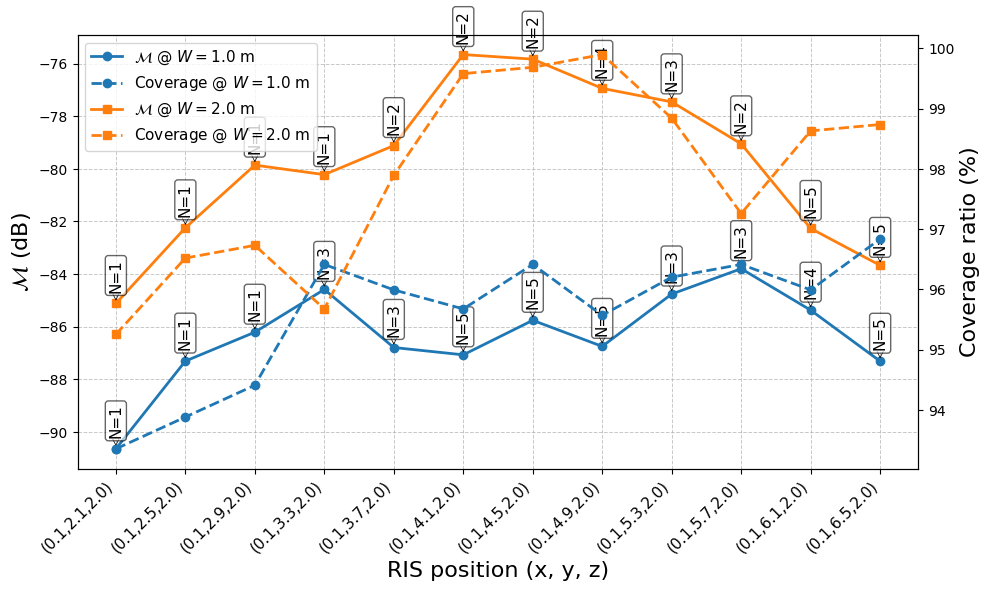

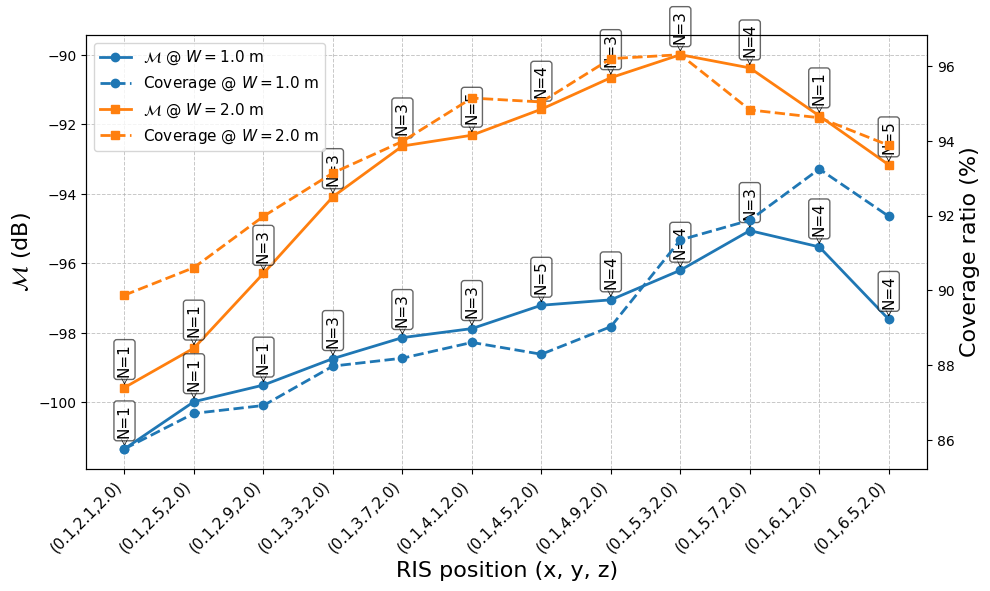

In [1]:
import json
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

# Parse config string
def parse_config(config_str):
    return ast.literal_eval(config_str)

# Group best metrics by (W, RIS_pos) over N
def group_metrics_by_ris_pos(perf_data, coverage_data):
    grouped = defaultdict(lambda: defaultdict(dict))
    for config_str, perf in perf_data.items():
        if config_str == "no_RIS_contribution":
            continue
        cov = coverage_data.get(config_str, 0.0)
        N, W, ris_pos = parse_config(config_str)
        current = grouped[W].get(ris_pos)
        if current is None or perf > current["performance"]:
            grouped[W][ris_pos] = {
                "performance": perf,
                "coverage_ratio": cov,
                "N": N
            }
    return grouped

# Plot performance and coverage over categorical RIS_pos
def plot_line_performance_and_coverage_by_RIS_pos(grouped_data, widths_to_plot):
    all_ris_pos = sorted({pos for width in widths_to_plot for pos in grouped_data[width].keys()})
    pos_labels = [f"({p[0]:.1f},{p[1]:.1f},{p[2]:.1f})" for p in all_ris_pos]
    x = list(range(len(all_ris_pos)))  # numerical positions for plotting

    fig, ax1 = plt.subplots(figsize=(max(10, len(x) * 0.6), 6))
    ax2 = ax1.twinx()

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    markers = ['o', 's', '^', 'D']
    all_lines = []
    all_labels = []

    for i, width in enumerate(widths_to_plot):
        performance = []
        coverage = []
        Ns = []
        for pos in all_ris_pos:
            entry = grouped_data[width].get(pos)
            if entry:
                performance.append(entry["performance"])
                coverage.append(entry["coverage_ratio"])
                Ns.append(entry["N"])
            else:
                performance.append(None)
                coverage.append(None)
                Ns.append(None)

        # Performance metric line
        line1, = ax1.plot(x, performance, marker=markers[i], linestyle='-', linewidth=2,
                          color=colors[i], label=fr"$\mathcal{{M}}$ @ $W={width}$ m")
        # Coverage ratio line
        line2, = ax2.plot(x, coverage, marker=markers[i], linestyle='--', linewidth=2,
                          color=colors[i], label=fr"Coverage @ $W={width}$ m")

        all_lines.extend([line1, line2])
        all_labels.extend([line1.get_label(), line2.get_label()])

        # Annotate N on performance line
        for xi, yi, N in zip(x, performance, Ns):  # <-- Now uses `performance` and `ax1`
            if N is not None:
                ax1.annotate(f"N={N}",
                             xy=(xi, yi), xytext=(0, 8),
                             textcoords="offset points", fontsize=11,
                             ha='center', va='bottom', rotation=90,
                             bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6),
                             arrowprops=dict(arrowstyle="->", lw=0.5))


    ax1.set_xlabel("RIS position (x, y, z)", fontsize=16)
    ax1.set_ylabel("$\mathcal{M}$ (dB)", fontsize=16)
    ax2.set_ylabel("Coverage ratio (%)", fontsize=16)

    ax1.set_xticks(x)
    ax1.set_xticklabels(pos_labels, rotation=45, ha='right', fontsize=11)
    ax1.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    ax1.legend(all_lines, all_labels, loc='best', fontsize=11)
    plt.tight_layout()
    plt.savefig("performance_and_coverage_vs_RIS_position_lines.png", bbox_inches="tight")
    plt.show()



# === Example usage ===
if __name__ == "__main__":
    json_path_perf = "Paper-OJAP\\Data results\\Gradient-based\\metrics_RIS_height_1.0_extended-N-1-2-3-4-5.json"
    json_path_cov = "Paper-OJAP\\Data results\\Gradient-based\\metrics_coverage_ratio_RIS_height_1.0_extended-N-1-2-3-4-5.json"

    with open(json_path_perf, 'r') as f1, open(json_path_cov, 'r') as f2:
        perf_data = json.load(f1)
        coverage_data = json.load(f2)

    widths_to_plot = [1.0, 2.0]
    grouped_data = group_metrics_by_ris_pos(perf_data, coverage_data)
    plot_line_performance_and_coverage_by_RIS_pos(grouped_data, widths_to_plot)

    json_path_perf = "Paper-OJAP\\Data results\\Distance-based\\metrics_RIS_height_1.0_distance_extended.json"
    json_path_cov = "Paper-OJAP\\Data results\\Distance-based\\metrics_coverage_ratio_RIS_height_1.0_distance_extended.json"

    with open(json_path_perf, 'r') as f1, open(json_path_cov, 'r') as f2:
        perf_data = json.load(f1)
        coverage_data = json.load(f2)

    widths_to_plot = [1.0, 2.0]
    grouped_data = group_metrics_by_ris_pos(perf_data, coverage_data)
    plot_line_performance_and_coverage_by_RIS_pos(grouped_data, widths_to_plot)    
